Adapted from [ner_with_bilstm_and_crf](https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook)
Altigran Soares da Silva
IComp/UFAM - 15/03/2021


In [ ]:
# For this to work, use:
# Keras 2.3.1
# Also remember to use GPU in your colab notebook
%tensorflow_version 2.x

# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from math import nan
from future.utils import iteritems
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import json
import pickle
import time
from requests import get

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader

!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer

!pip install seqeval
from seqeval.metrics import f1_score, classification_report

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 15.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 15.4 MB/s 
     |████████████████████████████████| 101 kB 9.7 MB/s 
     |████████████████████████████████| 6.6 MB 52.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=9304c00857413ff5de57fa3fbf80d763c12e9837ebfbde2672309fa98e30d2da
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [ ]:
# Code to read csv file from google drive into Colaboratory:
DATA_TRAINING_FILE_ID = '1iTLWWB9aFjtjVz7Kq4ku2syjhINCz2_q'
DATA_TRAINING_FILENAME = 'ner_training_dataset.csv'
DATA_DEV_FILE_ID = '1fB1Mp-6_zxGC3NO5sMX23B-LPyYzc9I9'
DATA_DEV_FILENAME = 'ner_validation_dataset.csv'
DATA_TEST_FILE_ID = '17vmu2VXPwvOKuQ66kDY7t38dFqkYccvx'
DATA_TEST_FILENAME = 'ner_test_dataset.csv'
BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
downloaded_training = drive.CreateFile({'id': DATA_TRAINING_FILE_ID})
downloaded_training.GetContentFile(DATA_TRAINING_FILENAME)
downloaded_dev = drive.CreateFile({'id': DATA_DEV_FILE_ID})
downloaded_dev.GetContentFile(DATA_DEV_FILENAME)
downloaded_test = drive.CreateFile({'id': DATA_TEST_FILE_ID})
downloaded_test.GetContentFile(DATA_TEST_FILENAME)

# Read the csv file in a dataframe called "data"
training_data = pd.read_csv(DATA_TRAINING_FILENAME, encoding="latin1")
dev_data = pd.read_csv(DATA_DEV_FILENAME, encoding="latin1")
test_data = pd.read_csv(DATA_TEST_FILENAME, encoding="latin1")
# Fill NaN values using the specified method
# Ffill propagate last valid observation/value forward to next valid 
training_data = training_data.fillna(method="ffill")
dev_data = dev_data.fillna(method="ffill")
test_data = test_data.fillna(method="ffill")

notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

In [ ]:
# Explore the input dataset
print("Number of training sentences: ", len(training_data.groupby(['Sentence #'])))
print("Number of dev sentences: ", len(dev_data.groupby(['Sentence #'])))
print("Number of test sentences: ", len(test_data.groupby(['Sentence #'])))

training_words = list(set(training_data["Word"].values))
n_training_words = len(training_words)
print("Number of words in the training dataset: ", n_training_words)
dev_words = list(set(dev_data["Word"].values))
n_dev_words = len(dev_words)
print("Number of words in the dev dataset: ", n_dev_words)
test_words = list(set(test_data["Word"].values))
n_test_words = len(test_words)
print("Number of words in the test dataset: ", n_test_words)

training_tags = list(set(training_data["Tag"].values))
print("Tags in the training dataset:", training_tags)
n_training_tags = len(training_tags)
print("Number of Labels in the training dataset: ", n_training_tags)
dev_tags = list(set(dev_data["Tag"].values))
print("Tags in the dev dataset:", dev_tags)
n_dev_tags = len(dev_tags)
print("Number of Labels in the dev dataset: ", n_dev_tags)
test_tags = list(set(test_data["Tag"].values))
print("Tags in the test dataset:", test_tags)
n_test_tags = len(test_tags)
print("Number of Labels in the test dataset: ", n_test_tags)

print("What the training dataset looks like:")
# Show the first 10 rows
training_data.head(n=10)

Number of training sentences:  1000
Number of dev sentences:  1000
Number of test sentences:  1000
Number of words in the training dataset:  10405
Number of words in the dev dataset:  10246
Number of words in the test dataset:  10814
Tags in the training dataset: ['I-Disease', 'I-Chemical', 'B-Disease', 'B-Chemical', 'O']
Number of Labels in the training dataset:  5
Tags in the dev dataset: ['I-Disease', 'I-Chemical', 'B-Disease', 'B-Chemical', 'O']
Number of Labels in the dev dataset:  5
Tags in the test dataset: ['I-Disease', 'I-Chemical', 'B-Disease', 'B-Chemical', 'O']
Number of Labels in the test dataset:  5
What the training dataset looks like:


,Sentence #,Word,Tag
0,Sentence: 1,Naloxone,B-Chemical
1,Sentence: 1,reverses,O
2,Sentence: 1,the,O
3,Sentence: 1,antihypertensive,O
4,Sentence: 1,effect,O
5,Sentence: 1,of,O
6,Sentence: 1,clonidine,B-Chemical
7,Sentence: 1,.,O
8,Sentence: 2,In,O
9,Sentence: 2,unanesthetized,O


In [ ]:
# SentenceGetter re-organize "data" as an arry of sentences
# Each sentence is a list of pairs <word,tag> 
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["Word"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped = self.dataset.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

training_getter = SentenceGetter(training_data)
training_sentences = training_getter.sentences
dev_getter = SentenceGetter(dev_data)
dev_sentences = dev_getter.sentences
test_getter = SentenceGetter(test_data)
test_sentences = test_getter.sentences

# Example: training sentence #200 
training_sentences[200]

[('Intravenous', 'O'),
 ('administration', 'O'),
 ('of', 'O'),
 ('prochlorperazine', 'B-Chemical'),
 ('by', 'O'),
 ('15', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('infusion', 'O'),
 ('versus', 'O'),
 ('2', 'O'),
 ('-', 'O'),
 ('minute', 'O'),
 ('bolus', 'O'),
 ('does', 'O'),
 ('not', 'O'),
 ('affect', 'O'),
 ('the', 'O'),
 ('incidence', 'O'),
 ('of', 'O'),
 ('akathisia', 'B-Disease'),
 (':', 'O'),
 ('a', 'O'),
 ('prospective', 'O'),
 (',', 'O'),
 ('randomized', 'O'),
 (',', 'O'),
 ('controlled', 'O'),
 ('trial', 'O'),
 ('.', 'O')]

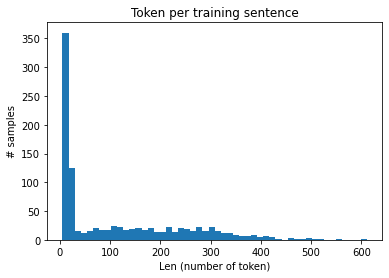

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in training_sentences], bins=50)
plt.title('Token per training sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

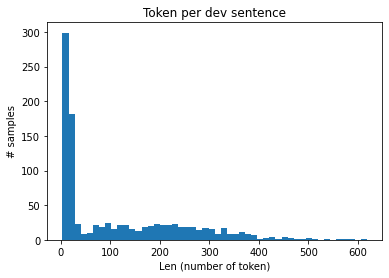

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in dev_sentences], bins=50)
plt.title('Token per dev sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

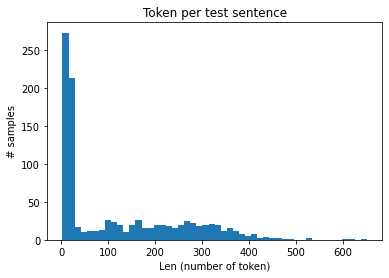

In [ ]:
# Explore set of sentences
# Plot sentences by length
plt.hist([len(s) for s in test_sentences], bins=50)
plt.title('Token per test sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [ ]:
# Keras (and most other ML packages) expect all the ids to be numeric, 
# this is an optimisation to save memory. 
# We will create the following dictionaries:
# word2idx: assign a numeric index to each word in the dataset
# idx2word: inverted version of word2idx
# tag2idx: assign a numeric index to each tag in the dataset
# idx2tag: inverted version of tag2idx

# Group training, dev and test data in order to create word-index dicts and to
# convert data to numeric indeces later
data = pd.concat([training_data, dev_data, test_data])

# words <= list of all words in the input dataset
words = list(set(data["Word"].values))
n_words = len(words)

# tags <= list of all tags in the input dataset
tags = []
for tag in set(data["Tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

# Dictionaries
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for w, i in iteritems(word2idx)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

# Index number for the word 'incidence'
print(word2idx['incidence'])
# Word of index 10
print(idx2word[10])
# Index number for the tag 'B-Disease'
print(tag2idx['B-Disease'])
# Tag of index 4
print(idx2tag[4])

5387
Flurothyl
2
O


In [ ]:
# Convert train, dev and test data to numeric values
X_train = [[word2idx[w[0]] for w in s] for s in training_sentences]
y_train = [[tag2idx[w[1]] for w in s] for s in training_sentences]

X_dev = [[word2idx[w[0]] for w in s] for s in dev_sentences]
y_dev = [[tag2idx[w[1]] for w in s] for s in dev_sentences]

X_test = [[word2idx[w[0]] for w in s] for s in test_sentences]
y_test = [[tag2idx[w[1]] for w in s] for s in test_sentences]

In [ ]:
# Use this function to randomly remove some points from training dataset
# Use removal percentage in decimal value. E.g.: if you set as 0.5, it will
# remove 50% of the dataset

def random_remove_data_points(dataset, labels, removal_percentage):
    if removal_percentage < 0 or removal_percentage > 1:
        raise Exception("Invalid removal percentage")
    
    if removal_percentage == 1:
        raise Exception("You can't remove the entire dataset")
    
    number_of_points_remaining = round(len(dataset)*(1-removal_percentage))

    try_again = True

    while try_again:
      random_idxs = np.random.choice(len(dataset), number_of_points_remaining, replace=False)
      cut_dataset_sentences = [dataset[i] for i in random_idxs]
      cut_dataset_labels = [labels[i] for i in random_idxs]
      cut_tags = list(set([idx2tag[j] for sub in cut_dataset_labels for j in sub]))

      if all(i in cut_tags for i in tags if i[:2] == "B-"):
        try_again = False

    return cut_dataset_sentences, cut_dataset_labels 

print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")
X_train, y_train = random_remove_data_points(X_train, y_train, 0.85)
print(f"Points in X_train before removal: {len(X_train)}")
print(f"Points in y_train before removal: {len(y_train)}")

Points in X_train before removal: 1000
Points in y_train before removal: 1000
Points in X_train before removal: 150
Points in y_train before removal: 150


In [ ]:
# Aux functions to save data and dicts, if data consistency is important
# and there is desire to not random split again

def save_backup_dataset(dataset, filename):
  dataset_df = pd.DataFrame(dataset)
  dataset_df.to_csv(filename, index=False)
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

def save_backup_dict(dict, filename):
  dict_file = open(filename, "wb")
  pickle.dump(dict, dict_file)
  dict_file.close()
  gfile = drive.CreateFile({'parents': [{'id': BACKUP_FOLDER_ID}]})
  gfile.SetContentFile(filename)
  gfile.Upload()

In [ ]:
# Uncomment this cell if you want to save data for further use

# Check some points before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

save_backup_dataset(X_train, X_train_filename)
save_backup_dataset(y_train, y_train_filename)
save_backup_dataset(X_dev, X_dev_filename)
save_backup_dataset(y_dev, y_dev_filename)
save_backup_dataset(X_test, X_test_filename)
save_backup_dataset(y_test, y_test_filename)

save_backup_dict(word2idx, word2idx_filename)
save_backup_dict(idx2word, idx2word_filename)
save_backup_dict(tag2idx, tag2idx_filename)
save_backup_dict(idx2tag, idx2tag_filename)

save_backup_dict({"n_words":n_words, "n_tags":n_tags}, others_filename)

[983, 14546, 768, 3398, 15336, 11063, 11392, 9858, 14797, 17713, 768, 2136, 1317, 13744, 14167, 9858, 5901, 15336, 12038, 11609, 13522, 6306, 17933, 4274, 15336, 2136, 8312, 15993, 768, 11063, 4814, 5545, 14304, 8571, 16088, 875, 12153, 768, 1824, 8482, 15336, 12038, 11063, 1948, 13233, 597, 6391, 15336, 12038, 11063, 1948, 8044, 11644, 16558, 5348, 17933]
[4, 4, 4, 4, 4, 3, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4]
[1262, 12230, 12110, 17081, 4975, 2938, 6196, 8312, 9878, 15140, 10071, 17933]
[2, 0, 0, 4, 3, 1, 2, 4, 4, 4, 4, 4]
[14978, 421, 13118, 2058, 17933, 2661, 14421, 15336, 673, 13846, 17933]
[3, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4]
5387
2
B-Disease
animal
18533
5


In [ ]:
# Uncomment this cell if you want to load saved data

# Re-import necessary libs
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pickle, math
from requests import get
import numpy as np
import matplotlib.pyplot as plt
import random
import time
%tensorflow_version 2.x
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
!pip install sentencepiece
!pip install transformers
from transformers import BertForTokenClassification, AutoTokenizer
import matplotlib.pyplot as plt
!pip install seqeval
from seqeval.metrics import f1_score, classification_report

BACKUP_FOLDER_ID = '1EwDUGjrtg8AiUhBFAImg5vEUXxYEqQcS'
notebook_filename = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']

X_train_filename = f'{notebook_filename}_X_train.csv'
y_train_filename = f'{notebook_filename}_y_train.csv'
X_dev_filename = f'{notebook_filename}_X_dev.csv'
y_dev_filename = f'{notebook_filename}_y_dev.csv'
X_test_filename = f'{notebook_filename}_X_test.csv'
y_test_filename = f'{notebook_filename}_y_test.csv'

word2idx_filename = f'{notebook_filename}_word2idx.pkl'
idx2word_filename = f'{notebook_filename}_idx2word.pkl'
tag2idx_filename = f'{notebook_filename}_tag2idx.pkl'
idx2tag_filename = f'{notebook_filename}_idx2tag.pkl'

others_filename = f'{notebook_filename}_others.pkl'

# Re-get important variables
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def get_backup_files_ids(folder_id):
  file_list = drive.ListFile({'q': "'{}' in parents and trashed=false".format(folder_id)}).GetList()
  return file_list

def load_backup_dataset(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.csv")

  dataset = pd.read_csv(f"{file_id}.csv", encoding="latin1")
  dataset = dataset.values.tolist()
  dataset = [ [ int(word) for word in sentence if str(word) != 'nan' ] for sentence in dataset]
  return dataset

def load_backup_dict(file_id):
  downloaded = drive.CreateFile({'id':file_id})
  downloaded.GetContentFile(f"{file_id}.pkl")

  dict_file = open(f"{file_id}.pkl", "rb")
  out_dict = pickle.load(dict_file)
  return out_dict

backup_file_list = get_backup_files_ids(BACKUP_FOLDER_ID)

X_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_train_filename][0]['id']
y_train_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_train_filename][0]['id']
X_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_dev_filename][0]['id']
y_dev_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_dev_filename][0]['id']
X_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == X_test_filename][0]['id']
y_test_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == y_test_filename][0]['id']

word2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == word2idx_filename][0]['id']
idx2word_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2word_filename][0]['id']
tag2idx_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == tag2idx_filename][0]['id']
idx2tag_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == idx2tag_filename][0]['id']

others_file_id = [backup_file for backup_file in backup_file_list if backup_file['title'] == others_filename][0]['id']

X_train = load_backup_dataset(X_train_file_id)
y_train = load_backup_dataset(y_train_file_id)
X_dev = load_backup_dataset(X_dev_file_id)
y_dev = load_backup_dataset(y_dev_file_id)
X_test = load_backup_dataset(X_test_file_id)
y_test = load_backup_dataset(y_test_file_id)

word2idx = load_backup_dict(word2idx_file_id)
idx2word = load_backup_dict(idx2word_file_id)
tag2idx = load_backup_dict(tag2idx_file_id)
idx2tag = load_backup_dict(idx2tag_file_id)

others = load_backup_dict(others_file_id)

n_words = others["n_words"]
n_tags = others["n_tags"]

# Check some points after loading data to see if they match the ones before saving
print(X_train[0])
print(y_train[0])
print(X_dev[0])
print(y_dev[0])
print(X_test[0])
print(y_test[0])
print(word2idx['incidence'])
print(tag2idx['B-Disease'])
print(idx2tag[2])
print(idx2word[100])
print(n_words)
print(n_tags)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 14.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.3 MB/s 
     |████████████████████████████████| 120 kB 75.5 MB/s 
     |████████████████████████████████| 6.6 MB 73.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 2.2 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=7954664c45240e5ea38280e35c49a3ff6dacd7fb65e6be35244ae6426eb07f75
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
[983, 14546, 768, 3398, 15336, 11063, 11392, 9858, 14797, 

In [ ]:
# Aux function to help in augmentation. Generates a dict where entities
# are the keys, and words are the values.

def create_entities_dict(dataset, labels, decoded_word=False):
    entities_dict = {}
    
    for i, sentence in enumerate(dataset):
        for k, word in enumerate(sentence):
            tag = idx2tag[labels[i][k]]
            if tag[:2] == "B-":
                if decoded_word:
                    word_list = [idx2word[word]]
                else:
                    word_list = [word]
                j = k + 1
                if j < len(labels[i]):
                    while idx2tag[labels[i][j]][:2] == "I-":
                        if decoded_word:
                            word_list.append(idx2word[dataset[i][j]])
                        else:
                            word_list.append(dataset[i][j])
                        j = j+1
                        if j == len(labels[i]):
                            break
                        
                if entities_dict.get(tag):
                    if word_list not in entities_dict[tag]:
                        entities_dict[tag].append(word_list)
                else:
                    entities_dict[tag] = [word_list]
                    
    return entities_dict

entities_dict = create_entities_dict(X_train, y_train)

In [ ]:
# Augmentation function using entity replacement technique.
# It will generate a new dataset, with X% more points based on
# the original dataset. E.g.: if you set augmentation percentage as 0.5 and dataset has
# 1000 points, it will generate a dataset with 1500 points.

def generate_sentences(dataset, labels, entities_dict, augmented_set_size_percentage):
    if augmented_set_size_percentage < 0:
        raise Exception("Invalid augmented set size percentage")

    number_of_new_sentences = math.ceil(augmented_set_size_percentage * len(dataset))
    random_idxs = np.random.choice(len(dataset), number_of_new_sentences, replace=True)
    
    base_sequences = [dataset[i] for i in random_idxs]
    base_labels = [labels[i] for i in random_idxs]

    new_sequences = []
    new_labels = []
    
    for k, sequence in enumerate(base_sequences):
        new_sequence = []
        new_label = []

        for i, word in enumerate(sequence):
            tag = idx2tag[base_labels[k][i]]
            if tag == "O":
                new_sequence.append(word)
                new_label.append(base_labels[k][i])
            elif tag[:2] == "B-":
                same_entities_type_tmp = entities_dict[tag]
                same_entities_type = np.array(same_entities_type_tmp, dtype=object)
                random_entity_idx = np.random.choice(len(same_entities_type), 1)[0]
                random_entity = same_entities_type[random_entity_idx]
                random_number_of_tokens = random.randint(1, len(random_entity))
                random_entity_tokens = np.random.choice(random_entity, random_number_of_tokens, replace = False).tolist()
                entity = tag[2:]
                decoded_token_labels = [f"I-{entity}" for token in random_entity_tokens]
                decoded_token_labels[0] = tag
                encoded_token_labels = [tag2idx[label] for label in decoded_token_labels]
                new_sequence = new_sequence + random_entity_tokens
                new_label = new_label + encoded_token_labels

        new_sequences.append(new_sequence)
        new_labels.append(new_label)

    augmented_X_train = dataset + new_sequences
    augmented_y_train = labels + new_labels

    print(f"Points in X_train after augmentation: {len(augmented_X_train)}")
    print(f"Points in y_train after augmentation: {len(augmented_y_train)}")

    return augmented_X_train, augmented_y_train

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class dataset(Dataset):
  def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

  def __getitem__(self, index):
        # step 1: get the sentence and word labels
        sentence = self.data.sentence[index]
        word_labels = self.data.word_labels[index].split(",") 

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)
        
        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [tag2idx[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100
        
        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
          if mapping[0] == 0 and mapping[1] != 0:
            # overwrite label
            encoded_labels[idx] = labels[i]
            i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)
        
        return item

  def __len__(self):
        return self.len

In [ ]:
# some configuration variables
LEARNING_RATE = 5e-05
MAX_GRAD_NORM = 10
TRAINING_STOP_LOSS_PERCENTAGE = 1

# Model creation function
def create_model(maxlen, n_labels, training_set, testing_set, validation_set):
  device = 'cuda' if cuda.is_available() else 'cpu'
  print("Device: ", device)

  model = BertForTokenClassification.from_pretrained('allenai/scibert_scivocab_uncased', num_labels=n_labels)
  model.to(device)

  optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

  TRAIN_BATCH_SIZE = round(0.05*len(training_set))
  if TRAIN_BATCH_SIZE > 16:
    TRAIN_BATCH_SIZE = 16
  if TRAIN_BATCH_SIZE < 10:
    TRAIN_BATCH_SIZE = 10

  VALID_BATCH_SIZE = round(0.1*len(validation_set))
  if VALID_BATCH_SIZE > 16:
    VALID_BATCH_SIZE = 16
  if VALID_BATCH_SIZE < 10:
    VALID_BATCH_SIZE = 10

  train_params = {'batch_size': TRAIN_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  test_params = {'batch_size': VALID_BATCH_SIZE,
                  'shuffle': True,
                  'num_workers': 0
                  }

  training_loader = DataLoader(training_set, **train_params)
  testing_loader = DataLoader(testing_set, **test_params)
  validation_loader = DataLoader(validation_set, **test_params)

  return model, device, optimizer, training_loader, testing_loader, validation_loader

In [ ]:
# Model training function
def train(model, device, optimizer, training_loader, epoch, training_stop_loss_percentage):
    tr_loss, tr_accuracy = 0, 0
    nb_tr_examples, nb_tr_steps = 0, 0
    tr_preds, tr_labels = [], []
    losses = []
    # put model in training mode
    model.train()
    
    for idx, batch in enumerate(training_loader):
        
        ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        labels = batch['labels'].to(device, dtype = torch.long)

        loss, tr_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
        tr_loss += loss.item()

        nb_tr_steps += 1
        nb_tr_examples += labels.size(0)
        
        if idx % 100==0:
            loss_step = tr_loss/nb_tr_steps
            print(f"Training loss per 100 training steps: {loss_step}")
            losses.append(loss_step)
            last_5_losses = losses[-5:]
            loss_min = min(last_5_losses)
            loss_max = max(last_5_losses)
            if len(last_5_losses) > 1 and (loss_max - loss_min)/loss_max < training_stop_loss_percentage/100:
              print("Stopping epoch...")
              break
           
        # compute training accuracy
        flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
        active_logits = tr_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
        flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
        
        # only compute accuracy at active labels
        active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        #active_labels = torch.where(active_accuracy, labels.view(-1), torch.tensor(-100).type_as(labels))
        
        labels = torch.masked_select(flattened_targets, active_accuracy)
        predictions = torch.masked_select(flattened_predictions, active_accuracy)
        
        tr_labels.extend(labels)
        tr_preds.extend(predictions)

        tmp_tr_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
        tr_accuracy += tmp_tr_accuracy
    
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(
            parameters=model.parameters(), max_norm=MAX_GRAD_NORM
        )
        
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = tr_loss / nb_tr_steps
    tr_accuracy = tr_accuracy / nb_tr_steps
    print(f"Training loss epoch: {epoch_loss}")
    print(f"Training accuracy epoch: {tr_accuracy}")

In [ ]:
# Model testing function
def test(model, device, testing_loader):
    print("Validating model...")
    # put model in evaluation mode
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_examples, nb_eval_steps = 0, 0
    eval_preds, eval_labels = [], []
    
    with torch.no_grad():
        for idx, batch in enumerate(testing_loader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            loss, eval_logits = model(input_ids=ids, attention_mask=mask, labels=labels, return_dict = False)
            
            eval_loss += loss.item()

            nb_eval_steps += 1
            nb_eval_examples += labels.size(0)
        
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = eval_logits.view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            eval_labels.extend(labels)
            eval_preds.extend(predictions)
            
            tmp_eval_accuracy = accuracy_score(labels.cpu().numpy(), predictions.cpu().numpy())
            eval_accuracy += tmp_eval_accuracy

    labels = [idx2tag[id.item()] for id in eval_labels]
    predictions = [idx2tag[id.item()] for id in eval_preds]
    
    eval_loss = eval_loss / nb_eval_steps
    eval_accuracy = eval_accuracy / nb_eval_steps
    print(f"Validation Loss: {eval_loss}")
    print(f"Validation Accuracy: {eval_accuracy}")

    return labels, predictions, eval_loss

In [ ]:
def create_train_and_validate_model(augmented_percentage):

  augmented_X_train, augmented_y_train = generate_sentences(X_train, y_train, entities_dict, augmented_percentage)

  maxlen_X_train = max([len(s) for s in augmented_X_train])
  maxlen_X_test = max([len(s) for s in X_test])
  maxlen_X_dev = max([len(s) for s in X_dev])
  maxlen_y_train = max([len(s) for s in augmented_y_train])
  maxlen_y_test = max([len(s) for s in y_test])
  maxlen_y_dev = max([len(s) for s in y_dev])

  maxlen = max([maxlen_X_train, maxlen_X_test, maxlen_X_dev, maxlen_y_train, maxlen_y_test, maxlen_y_dev])

  if maxlen > 512:
    maxlen = 512

  augmented_X_train_words = [[idx2word[word] for word in sentence] for sentence in augmented_X_train]
  X_dev_words = [[idx2word[word] for word in sentence] for sentence in X_dev]
  X_test_words = [[idx2word[word] for word in sentence] for sentence in X_test]
  augmented_y_train_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in augmented_y_train]
  y_dev_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_dev]
  y_test_tags = [','.join([idx2tag[tag] for tag in sentence]) for sentence in y_test]

  new_train_df = pd.DataFrame({"sentence": augmented_X_train_words, "word_labels": augmented_y_train_tags}).reset_index(drop=True)
  new_test_df = pd.DataFrame({"sentence": X_test_words, "word_labels": y_test_tags}).reset_index(drop=True)
  new_val_df = pd.DataFrame({"sentence": X_dev_words, "word_labels": y_dev_tags}).reset_index(drop=True)

  training_set = dataset(new_train_df, tokenizer, maxlen)
  testing_set = dataset(new_test_df, tokenizer, maxlen)
  validation_set = dataset(new_val_df, tokenizer, maxlen)

  model, device, optimizer, training_loader, testing_loader, val_loader = create_model(maxlen, len(tag2idx), training_set, testing_set, validation_set)

  training_start_time = time.clock()
  min_val_loss = 0
  MAX_PATIENCE = 5
  patience = 0

  for epoch in range(100):
    print(f"Training epoch: {epoch + 1}")
    if patience == MAX_PATIENCE:
      print("Patience limit reached")
      break
    train(model, device, optimizer, training_loader, epoch, TRAINING_STOP_LOSS_PERCENTAGE)
    labels, predictions, val_loss = test(model, device, val_loader)
    if ((min_val_loss == 0) or (min_val_loss != 0 and val_loss < min_val_loss)):
      min_val_loss = val_loss
      torch.save(model.state_dict(), 'checkpoint.pt')
      patience = 0
    else:
      patience = patience + 1
  print(f"Training duration: {(time.clock() - training_start_time)/60} minutes")

  checkpoint = torch.load('checkpoint.pt')
  model.load_state_dict(checkpoint)

  validation_start_time = time.clock()
  labels, predictions, test_loss = test(model, device, testing_loader)
  labels = [labels]
  predictions = [predictions]
  print(f"Validation duration: {(time.clock() - validation_start_time)/60} minutes")

  print("F1-score (test): {:.1%}".format(f1_score(labels, predictions)))
  print(classification_report(labels, predictions))

In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4990777969360352
Training loss epoch: 0.4194618284702301
Training accuracy epoch: 0.8749265461178226
Validating model...
Validation Loss: 0.19023412406917603
Validation Accuracy: 0.9263707537242951
Training epoch: 2
Training loss per 100 training steps: 0.16290000081062317
Training loss epoch: 0.1425094152490298
Training accuracy epoch: 0.9492293012197818
Validating model...
Validation Loss: 0.11208018021924156
Validation Accuracy: 0.9630327391489308
Training epoch: 3
Training loss per 100 training steps: 0.087051160633564
Training loss epoch: 0.07244521851340929
Training accuracy epoch: 0.9763261808690782
Validating model...
Validation Loss: 0.099541827208466
Validation Accuracy: 0.9661569720186242
Training epoch: 4
Training loss per 100 training steps: 0.028303788974881172
Training loss epoch: 0.03766401757796605
Training accuracy epoch: 0.9890094223856047
Validating model...
Validation Loss: 0.09976734960126499
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10282557392640719
Validation Accuracy: 0.9654550797448365
Validation duration: 0.3495913666666671 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.9%
              precision    recall  f1-score   support

    Chemical       0.87      0.83      0.85      4985
     Disease       0.67      0.79      0.73      4416

   micro avg       0.77      0.81      0.79      9401
   macro avg       0.77      0.81      0.79      9401
weighted avg       0.78      0.81      0.79      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8601641654968262
Training loss epoch: 0.473227263490359
Training accuracy epoch: 0.8570573636084639
Validating model...
Validation Loss: 0.2002146298450137
Validation Accuracy: 0.9277264962630043
Training epoch: 2
Training loss per 100 training steps: 0.18190811574459076
Training loss epoch: 0.1419524018963178
Training accuracy epoch: 0.9510926022901195
Validating model...
Validation Loss: 0.1290627026723491
Validation Accuracy: 0.9589350612892623
Training epoch: 3
Training loss per 100 training steps: 0.09834378957748413
Training loss epoch: 0.08471188768744468
Training accuracy epoch: 0.972917580192571
Validating model...
Validation Loss: 0.11343639048319014
Validation Accuracy: 0.9621388961373268
Training epoch: 4
Training loss per 100 training steps: 0.034217316657304764
Training loss epoch: 0.03748722299933434
Training accuracy epoch: 0.9888398287252929
Validating model...
Validation Loss: 0.10525811315765457
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10355480801728037
Validation Accuracy: 0.969182464111516
Validation duration: 0.35144680000000034 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.3%
              precision    recall  f1-score   support

    Chemical       0.88      0.86      0.87      4985
     Disease       0.75      0.75      0.75      4416

   micro avg       0.82      0.81      0.81      9401
   macro avg       0.82      0.80      0.81      9401
weighted avg       0.82      0.81      0.81      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6859725713729858
Training loss epoch: 0.48893580039342244
Training accuracy epoch: 0.8596815307099418
Validating model...
Validation Loss: 0.2172597615964829
Validation Accuracy: 0.928659867975515
Training epoch: 2
Training loss per 100 training steps: 0.19706334173679352
Training loss epoch: 0.14527425765991211
Training accuracy epoch: 0.9495511284450411
Validating model...
Validation Loss: 0.11963959239305012
Validation Accuracy: 0.9603396513032157
Training epoch: 3
Training loss per 100 training steps: 0.05993437021970749
Training loss epoch: 0.08347120756904285
Training accuracy epoch: 0.9732392719372159
Validating model...
Validation Loss: 0.12354150875693276
Validation Accuracy: 0.9609019177132511
Training epoch: 4
Training loss per 100 training steps: 0.05404423177242279
Training loss epoch: 0.051674072692791624
Training accuracy epoch: 0.9823667415220849
Validating model...
Validation Loss: 0.11038399109291652
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1058772165505659
Validation Accuracy: 0.967619114698123
Validation duration: 0.35165838333333377 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.1%
              precision    recall  f1-score   support

    Chemical       0.83      0.91      0.87      4985
     Disease       0.72      0.77      0.74      4416

   micro avg       0.78      0.85      0.81      9401
   macro avg       0.78      0.84      0.81      9401
weighted avg       0.78      0.85      0.81      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5308793783187866
Training loss epoch: 0.4400227636098862
Training accuracy epoch: 0.8743034834264203
Validating model...
Validation Loss: 0.19602745901497584
Validation Accuracy: 0.9235046489553353
Training epoch: 2
Training loss per 100 training steps: 0.21973615884780884
Training loss epoch: 0.1339026615023613
Training accuracy epoch: 0.9550926976990642
Validating model...
Validation Loss: 0.11915738620455303
Validation Accuracy: 0.9594541547630139
Training epoch: 3
Training loss per 100 training steps: 0.049347806721925735
Training loss epoch: 0.06404472663998603
Training accuracy epoch: 0.9797383042203012
Validating model...
Validation Loss: 0.10661999479172722
Validation Accuracy: 0.9656973761411167
Training epoch: 4
Training loss per 100 training steps: 0.03783871605992317
Training loss epoch: 0.04055557747681936
Training accuracy epoch: 0.9865423379745873
Validating model...
Validation Loss: 0.09985010195819158
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10045007149141932
Validation Accuracy: 0.9668832260037352
Validation duration: 0.3512778833333338 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

    Chemical       0.89      0.86      0.87      4985
     Disease       0.71      0.74      0.73      4416

   micro avg       0.80      0.80      0.80      9401
   macro avg       0.80      0.80      0.80      9401
weighted avg       0.81      0.80      0.80      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.482789397239685
Training loss epoch: 0.42559551894664766
Training accuracy epoch: 0.8758674859895527
Validating model...
Validation Loss: 0.18190772050902956
Validation Accuracy: 0.935523576801477
Training epoch: 2
Training loss per 100 training steps: 0.19301749765872955
Training loss epoch: 0.1290696201225122
Training accuracy epoch: 0.957483290264631
Validating model...
Validation Loss: 0.12531491664666977
Validation Accuracy: 0.9594917989020312
Training epoch: 3
Training loss per 100 training steps: 0.10210469365119934
Training loss epoch: 0.07083007246255875
Training accuracy epoch: 0.9779585001951747
Validating model...
Validation Loss: 0.10639410371345187
Validation Accuracy: 0.9661258610319513
Training epoch: 4
Training loss per 100 training steps: 0.03330470994114876
Training loss epoch: 0.035684287548065186
Training accuracy epoch: 0.9892742301740121
Validating model...
Validation Loss: 0.10232524686152973
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1036660417559601
Validation Accuracy: 0.9683677655217984
Validation duration: 0.3516543333333326 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.5%
              precision    recall  f1-score   support

    Chemical       0.85      0.88      0.87      4985
     Disease       0.73      0.78      0.76      4416

   micro avg       0.79      0.84      0.82      9401
   macro avg       0.79      0.83      0.81      9401
weighted avg       0.80      0.84      0.82      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6376373767852783
Training loss epoch: 0.4929464727640152
Training accuracy epoch: 0.8574679889594595
Validating model...
Validation Loss: 0.22718443851622325
Validation Accuracy: 0.9385114632488528
Training epoch: 2
Training loss per 100 training steps: 0.2178415209054947
Training loss epoch: 0.1577257628242175
Training accuracy epoch: 0.9478797950118145
Validating model...
Validation Loss: 0.1228784066107538
Validation Accuracy: 0.9607057383551219
Training epoch: 3
Training loss per 100 training steps: 0.19663448631763458
Training loss epoch: 0.07763861864805222
Training accuracy epoch: 0.9766818482157082
Validating model...
Validation Loss: 0.10452769631667742
Validation Accuracy: 0.9657094303872474
Training epoch: 4
Training loss per 100 training steps: 0.052064765244722366
Training loss epoch: 0.03889574160178502
Training accuracy epoch: 0.9880419257178794
Validating model...
Validation Loss: 0.10756114231688636
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10924623965743989
Validation Accuracy: 0.963393481681479
Validation duration: 0.35125638333333126 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.8%
              precision    recall  f1-score   support

    Chemical       0.82      0.87      0.85      4985
     Disease       0.66      0.76      0.71      4416

   micro avg       0.74      0.82      0.78      9401
   macro avg       0.74      0.82      0.78      9401
weighted avg       0.74      0.82      0.78      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7074519395828247
Training loss epoch: 0.4758491943279902
Training accuracy epoch: 0.8628433807149827
Validating model...
Validation Loss: 0.21650936135223933
Validation Accuracy: 0.9340951247127216
Training epoch: 2
Training loss per 100 training steps: 0.32299289107322693
Training loss epoch: 0.15510027756293615
Training accuracy epoch: 0.94646992195289
Validating model...
Validation Loss: 0.12264971908122774
Validation Accuracy: 0.9587837361897155
Training epoch: 3
Training loss per 100 training steps: 0.0693696066737175
Training loss epoch: 0.08536661565303802
Training accuracy epoch: 0.9707272444047639
Validating model...
Validation Loss: 0.1014332002590573
Validation Accuracy: 0.9655589632424231
Training epoch: 4
Training loss per 100 training steps: 0.04507221281528473
Training loss epoch: 0.043657675633827844
Training accuracy epoch: 0.985410980229834
Validating model...
Validation Loss: 0.10052062381827642
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0982858527392622
Validation Accuracy: 0.9680064184325275
Validation duration: 0.3518063833333334 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

    Chemical       0.87      0.87      0.87      4985
     Disease       0.75      0.72      0.74      4416

   micro avg       0.82      0.80      0.81      9401
   macro avg       0.81      0.80      0.80      9401
weighted avg       0.81      0.80      0.81      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6100986003875732
Training loss epoch: 0.47542431950569153
Training accuracy epoch: 0.8602165703857706
Validating model...
Validation Loss: 0.20926562945048013
Validation Accuracy: 0.9257176173786179
Training epoch: 2
Training loss per 100 training steps: 0.19285281002521515
Training loss epoch: 0.14597498029470443
Training accuracy epoch: 0.9499914426255588
Validating model...
Validation Loss: 0.12613998862012984
Validation Accuracy: 0.9575320827427939
Training epoch: 3
Training loss per 100 training steps: 0.09683724492788315
Training loss epoch: 0.07198604717850685
Training accuracy epoch: 0.976095457256145
Validating model...
Validation Loss: 0.10994303013597216
Validation Accuracy: 0.9642241140451274
Training epoch: 4
Training loss per 100 training steps: 0.021362537518143654
Training loss epoch: 0.03393026410291592
Training accuracy epoch: 0.9896873696023347
Validating model...
Validation Loss: 0.11083987272448009
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10597160417172644
Validation Accuracy: 0.9649629381503582
Validation duration: 0.3497959333333332 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.6%
              precision    recall  f1-score   support

    Chemical       0.88      0.81      0.84      4985
     Disease       0.67      0.74      0.70      4416

   micro avg       0.77      0.78      0.78      9401
   macro avg       0.78      0.78      0.77      9401
weighted avg       0.78      0.78      0.78      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5949071645736694
Training loss epoch: 0.43754829665025075
Training accuracy epoch: 0.8661200507055553
Validating model...
Validation Loss: 0.17972015991570459
Validation Accuracy: 0.9388134922915778
Training epoch: 2
Training loss per 100 training steps: 0.17178337275981903
Training loss epoch: 0.13598369558652243
Training accuracy epoch: 0.9550272102372942
Validating model...
Validation Loss: 0.12000452431421431
Validation Accuracy: 0.9603398376251723
Training epoch: 3
Training loss per 100 training steps: 0.08456610143184662
Training loss epoch: 0.07175939679145812
Training accuracy epoch: 0.9771699049948861
Validating model...
Validation Loss: 0.10831305893167617
Validation Accuracy: 0.9646495587641215
Training epoch: 4
Training loss per 100 training steps: 0.05226920545101166
Training loss epoch: 0.03835588706036409
Training accuracy epoch: 0.9882569404791985
Validating model...
Validation Loss: 0.10630585596201912
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10320864186163932
Validation Accuracy: 0.9675997207663115
Validation duration: 0.3497474333333306 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.3%
              precision    recall  f1-score   support

    Chemical       0.89      0.84      0.86      4985
     Disease       0.72      0.76      0.74      4416

   micro avg       0.81      0.80      0.80      9401
   macro avg       0.81      0.80      0.80      9401
weighted avg       0.81      0.80      0.80      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 150
Points in y_train after augmentation: 150
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6404882669448853
Training loss epoch: 0.44928918878237406
Training accuracy epoch: 0.8623022545224256
Validating model...
Validation Loss: 0.19091749143978906
Validation Accuracy: 0.9323324693374369
Training epoch: 2
Training loss per 100 training steps: 0.17069697380065918
Training loss epoch: 0.1308654233813286
Training accuracy epoch: 0.9544974564666088
Validating model...
Validation Loss: 0.11892797443128768
Validation Accuracy: 0.9608539889349456
Training epoch: 3
Training loss per 100 training steps: 0.07357734441757202
Training loss epoch: 0.0620709386964639
Training accuracy epoch: 0.9795695012498236
Validating model...
Validation Loss: 0.10630318829937586
Validation Accuracy: 0.9651624562403323
Training epoch: 4
Training loss per 100 training steps: 0.02465793862938881
Training loss epoch: 0.03078875405093034
Training accuracy epoch: 0.9912234279486065
Validating model...
Validation Loss: 0.11038025291193099
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10703189558689556
Validation Accuracy: 0.9648402261853636
Validation duration: 0.3521299833333311 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.2%
              precision    recall  f1-score   support

    Chemical       0.85      0.84      0.85      4985
     Disease       0.68      0.76      0.71      4416

   micro avg       0.77      0.80      0.78      9401
   macro avg       0.77      0.80      0.78      9401
weighted avg       0.77      0.80      0.78      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.25

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 25.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7454485893249512
Training loss epoch: 0.43046826751608597
Training accuracy epoch: 0.8732096424234822
Validating model...
Validation Loss: 0.17429996163599074
Validation Accuracy: 0.9417001373177148
Training epoch: 2
Training loss per 100 training steps: 0.1474444717168808
Training loss epoch: 0.11433203714458566
Training accuracy epoch: 0.9634588109795601
Validating model...
Validation Loss: 0.11587552891837226
Validation Accuracy: 0.9610546510393716
Training epoch: 3
Training loss per 100 training steps: 0.056888412684202194
Training loss epoch: 0.06207718484495815
Training accuracy epoch: 0.9784268904679884
Validating model...
Validation Loss: 0.103794785896464
Validation Accuracy: 0.9663581202327133
Training epoch: 4
Training loss per 100 training steps: 0.03092326410114765
Training loss epoch: 0.030170582921097155
Training accuracy epoch: 0.9908504469412324
Validating model...
Validation Loss: 0.1034120282246953
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10042603763322981
Validation Accuracy: 0.9683805111591187
Validation duration: 0.3515428166666652 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

    Chemical       0.87      0.89      0.88      4985
     Disease       0.71      0.76      0.73      4416

   micro avg       0.79      0.83      0.81      9401
   macro avg       0.79      0.82      0.80      9401
weighted avg       0.79      0.83      0.81      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8326712846755981
Training loss epoch: 0.429307454510739
Training accuracy epoch: 0.8692504203635858
Validating model...
Validation Loss: 0.17355239817074367
Validation Accuracy: 0.941161136103839
Training epoch: 2
Training loss per 100 training steps: 0.16592717170715332
Training loss epoch: 0.11701330581777974
Training accuracy epoch: 0.9609324215131644
Validating model...
Validation Loss: 0.11642178017941732
Validation Accuracy: 0.9610423066941188
Training epoch: 3
Training loss per 100 training steps: 0.07140567153692245
Training loss epoch: 0.053156528327810135
Training accuracy epoch: 0.9836509754129515
Validating model...
Validation Loss: 0.10828396524228746
Validation Accuracy: 0.9665031686605662
Training epoch: 4
Training loss per 100 training steps: 0.018294507637619972
Training loss epoch: 0.031307098357693144
Training accuracy epoch: 0.9902897501367116
Validating model...
Validation Loss: 0.10507348049727697
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1054246515508682
Validation Accuracy: 0.9677416608116098
Validation duration: 0.351704483333333 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

    Chemical       0.87      0.89      0.88      4985
     Disease       0.72      0.75      0.74      4416

   micro avg       0.80      0.83      0.81      9401
   macro avg       0.80      0.82      0.81      9401
weighted avg       0.80      0.83      0.81      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3863242864608765
Training loss epoch: 0.36941045052126836
Training accuracy epoch: 0.889850617645048
Validating model...
Validation Loss: 0.15396344366054687
Validation Accuracy: 0.9491344618788348
Training epoch: 2
Training loss per 100 training steps: 0.16955892741680145
Training loss epoch: 0.11940948037724745
Training accuracy epoch: 0.9610167241577102
Validating model...
Validation Loss: 0.10409969777341872
Validation Accuracy: 0.963663991152524
Training epoch: 3
Training loss per 100 training steps: 0.045208051800727844
Training loss epoch: 0.051784353036629524
Training accuracy epoch: 0.9828937854939273
Validating model...
Validation Loss: 0.0952397897721283
Validation Accuracy: 0.9686772382844606
Training epoch: 4
Training loss per 100 training steps: 0.044835299253463745
Training loss epoch: 0.02219379747188405
Training accuracy epoch: 0.993906924066487
Validating model...
Validation Loss: 0.10294330356613038
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.09622233650750583
Validation Accuracy: 0.9688476885101936
Validation duration: 0.3499775166666647 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.84      0.87      4985
     Disease       0.72      0.78      0.75      4416

   micro avg       0.80      0.81      0.81      9401
   macro avg       0.81      0.81      0.81      9401
weighted avg       0.81      0.81      0.81      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.804657220840454
Training loss epoch: 0.3829125001242286
Training accuracy epoch: 0.8813440824100901
Validating model...
Validation Loss: 0.15515809470698946
Validation Accuracy: 0.9497740464372348
Training epoch: 2
Training loss per 100 training steps: 0.08924983441829681
Training loss epoch: 0.10321749237022902
Training accuracy epoch: 0.9673447652421358
Validating model...
Validation Loss: 0.11186065861866587
Validation Accuracy: 0.9625114466569114
Training epoch: 3
Training loss per 100 training steps: 0.03694819658994675
Training loss epoch: 0.04822642150285997
Training accuracy epoch: 0.9848785262017281
Validating model...
Validation Loss: 0.10535195721165529
Validation Accuracy: 0.9663146559646495
Training epoch: 4
Training loss per 100 training steps: 0.01755981706082821
Training loss epoch: 0.02000580573650567
Training accuracy epoch: 0.9940823684357064
Validating model...
Validation Loss: 0.11707954889252073
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10367528904998113
Validation Accuracy: 0.9677869797482502
Validation duration: 0.35220443333333457 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.8%
              precision    recall  f1-score   support

    Chemical       0.91      0.79      0.84      4985
     Disease       0.75      0.75      0.75      4416

   micro avg       0.83      0.77      0.80      9401
   macro avg       0.83      0.77      0.80      9401
weighted avg       0.83      0.77      0.80      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9503388404846191
Training loss epoch: 0.42590988231332677
Training accuracy epoch: 0.8700158761598877
Validating model...
Validation Loss: 0.16640385807979674
Validation Accuracy: 0.9412993070948997
Training epoch: 2
Training loss per 100 training steps: 0.15561896562576294
Training loss epoch: 0.11293920129537582
Training accuracy epoch: 0.9632624477682037
Validating model...
Validation Loss: 0.10727784705777017
Validation Accuracy: 0.9633208861313421
Training epoch: 3
Training loss per 100 training steps: 0.05969162657856941
Training loss epoch: 0.0584476380363891
Training accuracy epoch: 0.9810487617169606
Validating model...
Validation Loss: 0.10548324285755081
Validation Accuracy: 0.9655358581149032
Training epoch: 4
Training loss per 100 training steps: 0.018890364095568657
Training loss epoch: 0.026400268077850342
Training accuracy epoch: 0.991520745604379
Validating model...
Validation Loss: 0.10650156515221747
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1013297832437924
Validation Accuracy: 0.967217398908007
Validation duration: 0.3497864666666677 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.1%
              precision    recall  f1-score   support

    Chemical       0.88      0.82      0.85      4985
     Disease       0.74      0.71      0.72      4416

   micro avg       0.81      0.77      0.79      9401
   macro avg       0.81      0.77      0.79      9401
weighted avg       0.81      0.77      0.79      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7212353944778442
Training loss epoch: 0.41835351288318634
Training accuracy epoch: 0.8740648580675048
Validating model...
Validation Loss: 0.1794698629823942
Validation Accuracy: 0.9403698351851163
Training epoch: 2
Training loss per 100 training steps: 0.10714701563119888
Training loss epoch: 0.12728098074072286
Training accuracy epoch: 0.959632808088531
Validating model...
Validation Loss: 0.11960066322769437
Validation Accuracy: 0.9604534764664915
Training epoch: 3
Training loss per 100 training steps: 0.037672579288482666
Training loss epoch: 0.05528992747789935
Training accuracy epoch: 0.9822549561649603
Validating model...
Validation Loss: 0.1023083186102292
Validation Accuracy: 0.9667348240977229
Training epoch: 4
Training loss per 100 training steps: 0.017202574759721756
Training loss epoch: 0.030052560136506434
Training accuracy epoch: 0.9911757890580727
Validating model...
Validation Loss: 0.1106264717167332
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.0987821618124606
Validation Accuracy: 0.9683216812862907
Validation duration: 0.34979481666665985 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.0%
              precision    recall  f1-score   support

    Chemical       0.89      0.84      0.86      4985
     Disease       0.72      0.75      0.73      4416

   micro avg       0.80      0.80      0.80      9401
   macro avg       0.80      0.79      0.80      9401
weighted avg       0.81      0.80      0.80      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.2522249221801758
Training loss epoch: 0.3259748691006711
Training accuracy epoch: 0.9085167989504351
Validating model...
Validation Loss: 0.14782511194547018
Validation Accuracy: 0.9538028133892292
Training epoch: 2
Training loss per 100 training steps: 0.11517508327960968
Training loss epoch: 0.09552015011247836
Training accuracy epoch: 0.9705824840552468
Validating model...
Validation Loss: 0.10702872855795754
Validation Accuracy: 0.9627784696806131
Training epoch: 3
Training loss per 100 training steps: 0.03586803376674652
Training loss epoch: 0.045971280748122616
Training accuracy epoch: 0.9852101301896707
Validating model...
Validation Loss: 0.10479733336066442
Validation Accuracy: 0.9671750278624345
Training epoch: 4
Training loss per 100 training steps: 0.015468385070562363
Training loss epoch: 0.022994540729805044
Training accuracy epoch: 0.9932821823740973
Validating model...
Validation Loss: 0.10852846763436756
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10194700773036669
Validation Accuracy: 0.9676205810133656
Validation duration: 0.3521303166666712 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

    Chemical       0.84      0.90      0.87      4985
     Disease       0.72      0.75      0.74      4416

   micro avg       0.79      0.83      0.81      9401
   macro avg       0.78      0.83      0.80      9401
weighted avg       0.79      0.83      0.81      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4127675294876099
Training loss epoch: 0.38055957226376785
Training accuracy epoch: 0.895899866117024
Validating model...
Validation Loss: 0.16285222366688742
Validation Accuracy: 0.9519737129266156
Training epoch: 2
Training loss per 100 training steps: 0.11869584023952484
Training loss epoch: 0.11066741966887524
Training accuracy epoch: 0.9650306366869439
Validating model...
Validation Loss: 0.1250475277266805
Validation Accuracy: 0.9567626060332859
Training epoch: 3
Training loss per 100 training steps: 0.077280193567276
Training loss epoch: 0.0553652866694488
Training accuracy epoch: 0.9823595212303587
Validating model...
Validation Loss: 0.10452724058949758
Validation Accuracy: 0.9679217520598525
Training epoch: 4
Training loss per 100 training steps: 0.03947402909398079
Training loss epoch: 0.02432666929732812
Training accuracy epoch: 0.9925668553615293
Validating model...
Validation Loss: 0.11324457102824771
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10089182581693407
Validation Accuracy: 0.9686645886142271
Validation duration: 0.3504157833333314 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 81.4%
              precision    recall  f1-score   support

    Chemical       0.88      0.87      0.87      4985
     Disease       0.75      0.75      0.75      4416

   micro avg       0.82      0.81      0.81      9401
   macro avg       0.81      0.81      0.81      9401
weighted avg       0.82      0.81      0.81      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.72661554813385
Training loss epoch: 0.408004807798486
Training accuracy epoch: 0.8722072066274056
Validating model...
Validation Loss: 0.16641910705301496
Validation Accuracy: 0.9424668687399913
Training epoch: 2
Training loss per 100 training steps: 0.15115875005722046
Training loss epoch: 0.1157609992905667
Training accuracy epoch: 0.9612461563095466
Validating model...
Validation Loss: 0.10564882935039581
Validation Accuracy: 0.9648764717278864
Training epoch: 3
Training loss per 100 training steps: 0.07820005714893341
Training loss epoch: 0.04867618374134365
Training accuracy epoch: 0.9862403500047022
Validating model...
Validation Loss: 0.116336585037292
Validation Accuracy: 0.9645296542239318
Training epoch: 4
Training loss per 100 training steps: 0.03388277068734169
Training loss epoch: 0.02852459065616131
Training accuracy epoch: 0.9911982400926463
Validating model...
Validation Loss: 0.10608518608505764
Validation Accur

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10509797717843737
Validation Accuracy: 0.96406752985612
Validation duration: 0.3515859000000091 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.0%
              precision    recall  f1-score   support

    Chemical       0.88      0.82      0.85      4985
     Disease       0.65      0.74      0.69      4416

   micro avg       0.76      0.78      0.77      9401
   macro avg       0.77      0.78      0.77      9401
weighted avg       0.77      0.78      0.77      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 188
Points in y_train after augmentation: 188
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7837786674499512
Training loss epoch: 0.42904282478909744
Training accuracy epoch: 0.8665920222726411
Validating model...
Validation Loss: 0.18017759174108505
Validation Accuracy: 0.9352828171709888
Training epoch: 2
Training loss per 100 training steps: 0.17973172664642334
Training loss epoch: 0.12445657308164396
Training accuracy epoch: 0.959097016644552
Validating model...
Validation Loss: 0.11338775403915889
Validation Accuracy: 0.9623782963560854
Training epoch: 3
Training loss per 100 training steps: 0.08033519983291626
Training loss epoch: 0.05120038074490271
Training accuracy epoch: 0.9845915565559338
Validating model...
Validation Loss: 0.10499614364807568
Validation Accuracy: 0.9666422495627955
Training epoch: 4
Training loss per 100 training steps: 0.01640843227505684
Training loss epoch: 0.024255941131789433
Training accuracy epoch: 0.9938323295432209
Validating model...
Validation Loss: 0.12332622860632246
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10519406406415834
Validation Accuracy: 0.9663777110041639
Validation duration: 0.3512834833333424 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.4%
              precision    recall  f1-score   support

    Chemical       0.86      0.89      0.87      4985
     Disease       0.68      0.74      0.71      4416

   micro avg       0.77      0.82      0.79      9401
   macro avg       0.77      0.82      0.79      9401
weighted avg       0.77      0.82      0.79      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 50.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8013231754302979
Training loss epoch: 0.38090585952713374
Training accuracy epoch: 0.8829210017869926
Validating model...
Validation Loss: 0.1650756744165269
Validation Accuracy: 0.9458824598837333
Training epoch: 2
Training loss per 100 training steps: 0.0824662372469902
Training loss epoch: 0.10769645621379216
Training accuracy epoch: 0.9673691085263033
Validating model...
Validation Loss: 0.12611624586676795
Validation Accuracy: 0.9576556747186522
Training epoch: 3
Training loss per 100 training steps: 0.050151336938142776
Training loss epoch: 0.0496034278933491
Training accuracy epoch: 0.9851949332059503
Validating model...
Validation Loss: 0.11303059183179386
Validation Accuracy: 0.9657383075409225
Training epoch: 4
Training loss per 100 training steps: 0.036658789962530136
Training loss epoch: 0.023903104033143746
Training accuracy epoch: 0.9930157810830652
Validating model...
Validation Loss: 0.11281956235567729
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11188659988461978
Validation Accuracy: 0.9677343154985556
Validation duration: 0.3526850166666767 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.7%
              precision    recall  f1-score   support

    Chemical       0.88      0.85      0.87      4985
     Disease       0.71      0.78      0.74      4416

   micro avg       0.80      0.82      0.81      9401
   macro avg       0.80      0.82      0.81      9401
weighted avg       0.80      0.82      0.81      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7554813623428345
Training loss epoch: 0.38492402860096525
Training accuracy epoch: 0.881705810622171
Validating model...
Validation Loss: 0.15232650982955145
Validation Accuracy: 0.9492794751438922
Training epoch: 2
Training loss per 100 training steps: 0.11081821471452713
Training loss epoch: 0.10028348863124847
Training accuracy epoch: 0.9665663654275534
Validating model...
Validation Loss: 0.11944257083629804
Validation Accuracy: 0.959908391860669
Training epoch: 3
Training loss per 100 training steps: 0.042311426252126694
Training loss epoch: 0.04224833766264575
Training accuracy epoch: 0.9880755824012214
Validating model...
Validation Loss: 0.11718894777789948
Validation Accuracy: 0.9659557967288491
Training epoch: 4
Training loss per 100 training steps: 0.017425263300538063
Training loss epoch: 0.01943175813981465
Training accuracy epoch: 0.9941909067216124
Validating model...
Validation Loss: 0.12808450985522496
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1159849644062065
Validation Accuracy: 0.9657217974021665
Validation duration: 0.35116635000000923 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.8%
              precision    recall  f1-score   support

    Chemical       0.85      0.87      0.86      4985
     Disease       0.66      0.76      0.71      4416

   micro avg       0.76      0.82      0.79      9401
   macro avg       0.76      0.82      0.79      9401
weighted avg       0.76      0.82      0.79      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7378737926483154
Training loss epoch: 0.3959873439300628
Training accuracy epoch: 0.8739514513549396
Validating model...
Validation Loss: 0.16968208953501687
Validation Accuracy: 0.9395467031218193
Training epoch: 2
Training loss per 100 training steps: 0.12744548916816711
Training loss epoch: 0.10847756727820351
Training accuracy epoch: 0.9647312479540531
Validating model...
Validation Loss: 0.10730698089750987
Validation Accuracy: 0.9641491817232408
Training epoch: 3
Training loss per 100 training steps: 0.0328754298388958
Training loss epoch: 0.0446695393572251
Training accuracy epoch: 0.9863289037827482
Validating model...
Validation Loss: 0.11004099835242544
Validation Accuracy: 0.9658065652524719
Training epoch: 4
Training loss per 100 training steps: 0.03269953653216362
Training loss epoch: 0.01951911761647179
Training accuracy epoch: 0.9944794668357533
Validating model...
Validation Loss: 0.11869139555427763
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11057664915209725
Validation Accuracy: 0.9624655800703624
Validation duration: 0.3514852499999961 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.9%
              precision    recall  f1-score   support

    Chemical       0.86      0.83      0.84      4985
     Disease       0.64      0.71      0.67      4416

   micro avg       0.75      0.77      0.76      9401
   macro avg       0.75      0.77      0.76      9401
weighted avg       0.76      0.77      0.76      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5214512348175049
Training loss epoch: 0.37366934759276255
Training accuracy epoch: 0.890629978414831
Validating model...
Validation Loss: 0.14378442414223203
Validation Accuracy: 0.9564468060446517
Training epoch: 2
Training loss per 100 training steps: 0.1383361667394638
Training loss epoch: 0.10340101076733499
Training accuracy epoch: 0.9660350081052309
Validating model...
Validation Loss: 0.11588081741143787
Validation Accuracy: 0.9591255045489201
Training epoch: 3
Training loss per 100 training steps: 0.062556691467762
Training loss epoch: 0.04620357212566194
Training accuracy epoch: 0.9861223695992594
Validating model...
Validation Loss: 0.11087246097269512
Validation Accuracy: 0.9659508094717176
Training epoch: 4
Training loss per 100 training steps: 0.027900787070393562
Training loss epoch: 0.02185524729568334
Training accuracy epoch: 0.9934268948801375
Validating model...
Validation Loss: 0.11343138789137204
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11039254625165273
Validation Accuracy: 0.9664123165231412
Validation duration: 0.3513223999999961 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.0%
              precision    recall  f1-score   support

    Chemical       0.89      0.86      0.87      4985
     Disease       0.69      0.76      0.72      4416

   micro avg       0.79      0.81      0.80      9401
   macro avg       0.79      0.81      0.80      9401
weighted avg       0.80      0.81      0.80      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6940879821777344
Training loss epoch: 0.37867744976565954
Training accuracy epoch: 0.8859721313269404
Validating model...
Validation Loss: 0.15921374753354087
Validation Accuracy: 0.9511083924181036
Training epoch: 2
Training loss per 100 training steps: 0.10013937205076218
Training loss epoch: 0.10020601767159644
Training accuracy epoch: 0.9682231013836067
Validating model...
Validation Loss: 0.11248757418185945
Validation Accuracy: 0.9613266662801611
Training epoch: 3
Training loss per 100 training steps: 0.09146863222122192
Training loss epoch: 0.04872844944752398
Training accuracy epoch: 0.9851891925677397
Validating model...
Validation Loss: 0.10976392089847535
Validation Accuracy: 0.9682050841838424
Training epoch: 4
Training loss per 100 training steps: 0.02415195107460022
Training loss epoch: 0.02043922848644711
Training accuracy epoch: 0.9939330678628437
Validating model...
Validation Loss: 0.1091699039652234
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11169928891791238
Validation Accuracy: 0.9684703073748626
Validation duration: 0.34898695000000163 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.8%
              precision    recall  f1-score   support

    Chemical       0.89      0.88      0.88      4985
     Disease       0.70      0.77      0.73      4416

   micro avg       0.79      0.83      0.81      9401
   macro avg       0.79      0.82      0.81      9401
weighted avg       0.80      0.83      0.81      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9190956354141235
Training loss epoch: 0.3790272580725806
Training accuracy epoch: 0.8819427170934359
Validating model...
Validation Loss: 0.155327523156764
Validation Accuracy: 0.9498714961608405
Training epoch: 2
Training loss per 100 training steps: 0.15786787867546082
Training loss epoch: 0.10375971169698806
Training accuracy epoch: 0.9651003491995389
Validating model...
Validation Loss: 0.11650060401076362
Validation Accuracy: 0.9599181035763968
Training epoch: 3
Training loss per 100 training steps: 0.07834113389253616
Training loss epoch: 0.04521263408518973
Training accuracy epoch: 0.9856832031223883
Validating model...
Validation Loss: 0.12272594993313153
Validation Accuracy: 0.9654057902135808
Training epoch: 4
Training loss per 100 training steps: 0.014770678244531155
Training loss epoch: 0.026421803626276198
Training accuracy epoch: 0.9920513204136815
Validating model...
Validation Loss: 0.11883031038774385
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11651036261566101
Validation Accuracy: 0.960594678157763
Validation duration: 0.35115811666667773 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.7%
              precision    recall  f1-score   support

    Chemical       0.89      0.77      0.83      4985
     Disease       0.65      0.73      0.69      4416

   micro avg       0.76      0.75      0.76      9401
   macro avg       0.77      0.75      0.76      9401
weighted avg       0.78      0.75      0.76      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.809381365776062
Training loss epoch: 0.37448883056640625
Training accuracy epoch: 0.8837341333133614
Validating model...
Validation Loss: 0.14988623110074845
Validation Accuracy: 0.9522474997736349
Training epoch: 2
Training loss per 100 training steps: 0.08883094787597656
Training loss epoch: 0.09936316080746196
Training accuracy epoch: 0.9671238978010938
Validating model...
Validation Loss: 0.10668820645364505
Validation Accuracy: 0.9643054485966421
Training epoch: 3
Training loss per 100 training steps: 0.05579208582639694
Training loss epoch: 0.039094289543018454
Training accuracy epoch: 0.9882143810629855
Validating model...
Validation Loss: 0.11160860121959731
Validation Accuracy: 0.9675200352880176
Training epoch: 4
Training loss per 100 training steps: 0.01694318652153015
Training loss epoch: 0.018609253800518456
Training accuracy epoch: 0.9948196668814747
Validating model...
Validation Loss: 0.12307201349546039
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.103966195668493
Validation Accuracy: 0.9637773383992775
Validation duration: 0.3521005999999943 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.0%
              precision    recall  f1-score   support

    Chemical       0.84      0.85      0.85      4985
     Disease       0.66      0.72      0.69      4416

   micro avg       0.75      0.79      0.77      9401
   macro avg       0.75      0.79      0.77      9401
weighted avg       0.75      0.79      0.77      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.834174394607544
Training loss epoch: 0.39261976310185026
Training accuracy epoch: 0.8826889397860058
Validating model...
Validation Loss: 0.15253790397019612
Validation Accuracy: 0.9507053253792757
Training epoch: 2
Training loss per 100 training steps: 0.1190197542309761
Training loss epoch: 0.09753969826159023
Training accuracy epoch: 0.9683435671191498
Validating model...
Validation Loss: 0.1153463540923974
Validation Accuracy: 0.9625636005728564
Training epoch: 3
Training loss per 100 training steps: 0.029257819056510925
Training loss epoch: 0.046053863263555934
Training accuracy epoch: 0.9863122388182399
Validating model...
Validation Loss: 0.11338249700410026
Validation Accuracy: 0.9657142886234896
Training epoch: 4
Training loss per 100 training steps: 0.01904068887233734
Training loss epoch: 0.02150913398890268
Training accuracy epoch: 0.9935650020548733
Validating model...
Validation Loss: 0.10944669522226803
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11248280415459284
Validation Accuracy: 0.967273838135648
Validation duration: 0.3530559000000115 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 80.9%
              precision    recall  f1-score   support

    Chemical       0.89      0.88      0.88      4985
     Disease       0.70      0.76      0.73      4416

   micro avg       0.80      0.82      0.81      9401
   macro avg       0.80      0.82      0.81      9401
weighted avg       0.80      0.82      0.81      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8968322277069092
Training loss epoch: 0.39716931467964534
Training accuracy epoch: 0.8801187705332743
Validating model...
Validation Loss: 0.1620411305200486
Validation Accuracy: 0.9485228795480778
Training epoch: 2
Training loss per 100 training steps: 0.1972305178642273
Training loss epoch: 0.09784924735625584
Training accuracy epoch: 0.9685990229602747
Validating model...
Validation Loss: 0.11399684739964348
Validation Accuracy: 0.9611370506845017
Training epoch: 3
Training loss per 100 training steps: 0.08268305659294128
Training loss epoch: 0.04426686137559868
Training accuracy epoch: 0.987777386630365
Validating model...
Validation Loss: 0.11497819435501856
Validation Accuracy: 0.966826985211816
Training epoch: 4
Training loss per 100 training steps: 0.016683652997016907
Training loss epoch: 0.02223302244341799
Training accuracy epoch: 0.9932292341018367
Validating model...
Validation Loss: 0.11752119725422254
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1103436533539068
Validation Accuracy: 0.9628059176831508
Validation duration: 0.34957328333333254 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.3%
              precision    recall  f1-score   support

    Chemical       0.90      0.77      0.83      4985
     Disease       0.66      0.73      0.70      4416

   micro avg       0.77      0.75      0.76      9401
   macro avg       0.78      0.75      0.76      9401
weighted avg       0.79      0.75      0.77      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 225
Points in y_train after augmentation: 225
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7816407680511475
Training loss epoch: 0.38889777873243603
Training accuracy epoch: 0.879972947994073
Validating model...
Validation Loss: 0.15085208333200878
Validation Accuracy: 0.9508277661457726
Training epoch: 2
Training loss per 100 training steps: 0.09884108603000641
Training loss epoch: 0.10487040380636851
Training accuracy epoch: 0.9653522501277356
Validating model...
Validation Loss: 0.12415312709552902
Validation Accuracy: 0.9575073032174922
Training epoch: 3
Training loss per 100 training steps: 0.0742347314953804
Training loss epoch: 0.049183214571149575
Training accuracy epoch: 0.984470098930159
Validating model...
Validation Loss: 0.1042909353143639
Validation Accuracy: 0.966600662727964
Training epoch: 4
Training loss per 100 training steps: 0.02468126453459263
Training loss epoch: 0.024084167421928475
Training accuracy epoch: 0.9931145311329371
Validating model...
Validation Loss: 0.11503477826241464
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10488791935264118
Validation Accuracy: 0.9667340911976189
Validation duration: 0.3509719166666703 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.5%
              precision    recall  f1-score   support

    Chemical       0.87      0.86      0.86      4985
     Disease       0.68      0.77      0.72      4416

   micro avg       0.77      0.82      0.79      9401
   macro avg       0.77      0.82      0.79      9401
weighted avg       0.78      0.82      0.80      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 0.75

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 75.0% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.3418527841567993
Training loss epoch: 0.3365645380247207
Training accuracy epoch: 0.9028629825747511
Validating model...
Validation Loss: 0.15593459362548495
Validation Accuracy: 0.949834270234477
Training epoch: 2
Training loss per 100 training steps: 0.13367480039596558
Training loss epoch: 0.09387688285538129
Training accuracy epoch: 0.9703294717982603
Validating model...
Validation Loss: 0.12567955628037453
Validation Accuracy: 0.9584954375816389
Training epoch: 3
Training loss per 100 training steps: 0.07253692299127579
Training loss epoch: 0.038110342320232166
Training accuracy epoch: 0.9884738013796222
Validating model...
Validation Loss: 0.11112978001908651
Validation Accuracy: 0.9664146937789393
Training epoch: 4
Training loss per 100 training steps: 0.015624463558197021
Training loss epoch: 0.015339855348602646
Training accuracy epoch: 0.9957587862177049
Validating model...
Validation Loss: 0.12548032710476528
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11203892948845076
Validation Accuracy: 0.9653538345310284
Validation duration: 0.3504169666666712 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.9%
              precision    recall  f1-score   support

    Chemical       0.83      0.90      0.86      4985
     Disease       0.72      0.74      0.73      4416

   micro avg       0.78      0.82      0.80      9401
   macro avg       0.77      0.82      0.79      9401
weighted avg       0.78      0.82      0.80      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7163406610488892
Training loss epoch: 0.3725617024160567
Training accuracy epoch: 0.8843942885050186
Validating model...
Validation Loss: 0.15382899817020174
Validation Accuracy: 0.9501597171050714
Training epoch: 2
Training loss per 100 training steps: 0.12060367316007614
Training loss epoch: 0.09585476294159889
Training accuracy epoch: 0.968711500609209
Validating model...
Validation Loss: 0.12187700044541132
Validation Accuracy: 0.9608849650033215
Training epoch: 3
Training loss per 100 training steps: 0.03411691635847092
Training loss epoch: 0.04151462488585994
Training accuracy epoch: 0.9871613790706981
Validating model...
Validation Loss: 0.11785982732498457
Validation Accuracy: 0.9654881994930997
Training epoch: 4
Training loss per 100 training steps: 0.01371521595865488
Training loss epoch: 0.017602974748505012
Training accuracy epoch: 0.9950567170489903
Validating model...
Validation Loss: 0.12547915866450657
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11617843576130413
Validation Accuracy: 0.9660974405568306
Validation duration: 0.35102341666667297 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.0%
              precision    recall  f1-score   support

    Chemical       0.90      0.84      0.87      4985
     Disease       0.70      0.71      0.70      4416

   micro avg       0.80      0.78      0.79      9401
   macro avg       0.80      0.78      0.79      9401
weighted avg       0.80      0.78      0.79      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8564859628677368
Training loss epoch: 0.40079966826098307
Training accuracy epoch: 0.8755056961808954
Validating model...
Validation Loss: 0.15696327068975993
Validation Accuracy: 0.9485266475072145
Training epoch: 2
Training loss per 100 training steps: 0.12981389462947845
Training loss epoch: 0.10311148031836465
Training accuracy epoch: 0.9658954813193251
Validating model...
Validation Loss: 0.12317944578235111
Validation Accuracy: 0.9589854942670102
Training epoch: 3
Training loss per 100 training steps: 0.07753320783376694
Training loss epoch: 0.046289934909769466
Training accuracy epoch: 0.9864078372185725
Validating model...
Validation Loss: 0.1148010931672558
Validation Accuracy: 0.966352386651274
Training epoch: 4
Training loss per 100 training steps: 0.022384466603398323
Training loss epoch: 0.02126473161791052
Training accuracy epoch: 0.9939897422582846
Validating model...
Validation Loss: 0.1268185232839887
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11376570271594184
Validation Accuracy: 0.964755705430669
Validation duration: 0.351050033333316 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.4%
              precision    recall  f1-score   support

    Chemical       0.83      0.87      0.85      4985
     Disease       0.70      0.72      0.71      4416

   micro avg       0.77      0.80      0.78      9401
   macro avg       0.77      0.79      0.78      9401
weighted avg       0.77      0.80      0.78      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6261698007583618
Training loss epoch: 0.3731850442432222
Training accuracy epoch: 0.8878580302031105
Validating model...
Validation Loss: 0.15745867871575886
Validation Accuracy: 0.9480460843582875
Training epoch: 2
Training loss per 100 training steps: 0.13547174632549286
Training loss epoch: 0.10072916817097437
Training accuracy epoch: 0.9680011462774974
Validating model...
Validation Loss: 0.11877023339981124
Validation Accuracy: 0.9604013840555571
Training epoch: 3
Training loss per 100 training steps: 0.057724691927433014
Training loss epoch: 0.05817312356971559
Training accuracy epoch: 0.980276597003727
Validating model...
Validation Loss: 0.10797101359755273
Validation Accuracy: 0.9638248115520051
Training epoch: 4
Training loss per 100 training steps: 0.02345573902130127
Training loss epoch: 0.02468331978612003
Training accuracy epoch: 0.9927967191021352
Validating model...
Validation Loss: 0.11303532401484156
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10690325764673096
Validation Accuracy: 0.9643688957701735
Validation duration: 0.35077571666667307 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.8%
              precision    recall  f1-score   support

    Chemical       0.91      0.81      0.86      4985
     Disease       0.65      0.77      0.70      4416

   micro avg       0.77      0.79      0.78      9401
   macro avg       0.78      0.79      0.78      9401
weighted avg       0.79      0.79      0.78      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8374255895614624
Training loss epoch: 0.36604419137750355
Training accuracy epoch: 0.8859299290049517
Validating model...
Validation Loss: 0.15732924013383806
Validation Accuracy: 0.9464269299920871
Training epoch: 2
Training loss per 100 training steps: 0.13907819986343384
Training loss epoch: 0.09627798607661611
Training accuracy epoch: 0.9679936987828419
Validating model...
Validation Loss: 0.11382803746632167
Validation Accuracy: 0.9609660677969035
Training epoch: 3
Training loss per 100 training steps: 0.054117362946271896
Training loss epoch: 0.043233103961462065
Training accuracy epoch: 0.9869153102025104
Validating model...
Validation Loss: 0.11692037486604281
Validation Accuracy: 0.9649909626381775
Training epoch: 4
Training loss per 100 training steps: 0.034886978566646576
Training loss epoch: 0.021597439733644325
Training accuracy epoch: 0.9939812309898917
Validating model...
Validation Loss: 0.12144853570868099
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11551048322802498
Validation Accuracy: 0.9609961042640304
Validation duration: 0.34784270000000106 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.2%
              precision    recall  f1-score   support

    Chemical       0.84      0.86      0.85      4985
     Disease       0.61      0.75      0.67      4416

   micro avg       0.72      0.81      0.76      9401
   macro avg       0.73      0.80      0.76      9401
weighted avg       0.73      0.81      0.77      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8433434963226318
Training loss epoch: 0.3916871334825243
Training accuracy epoch: 0.8840839515242855
Validating model...
Validation Loss: 0.154004856825821
Validation Accuracy: 0.9494982160726082
Training epoch: 2
Training loss per 100 training steps: 0.14099769294261932
Training loss epoch: 0.10267920401834306
Training accuracy epoch: 0.9642416393523231
Validating model...
Validation Loss: 0.11583035841347679
Validation Accuracy: 0.9620462646660697
Training epoch: 3
Training loss per 100 training steps: 0.049109913408756256
Training loss epoch: 0.04559568989844549
Training accuracy epoch: 0.9856094800047972
Validating model...
Validation Loss: 0.11358854434792957
Validation Accuracy: 0.965350937627687
Training epoch: 4
Training loss per 100 training steps: 0.033583469688892365
Training loss epoch: 0.024823914570290418
Training accuracy epoch: 0.992613508081879
Validating model...
Validation Loss: 0.12098785696758164
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11075454217100901
Validation Accuracy: 0.9648979853328218
Validation duration: 0.35186008333333424 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.0%
              precision    recall  f1-score   support

    Chemical       0.88      0.83      0.86      4985
     Disease       0.69      0.71      0.70      4416

   micro avg       0.79      0.77      0.78      9401
   macro avg       0.79      0.77      0.78      9401
weighted avg       0.79      0.77      0.78      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4209967851638794
Training loss epoch: 0.3367558008148557
Training accuracy epoch: 0.9006717651388945
Validating model...
Validation Loss: 0.14379478565284184
Validation Accuracy: 0.9539490247537156
Training epoch: 2
Training loss per 100 training steps: 0.11887819319963455
Training loss epoch: 0.08797202383478482
Training accuracy epoch: 0.9720255452932598
Validating model...
Validation Loss: 0.10787577247099271
Validation Accuracy: 0.9638460578935324
Training epoch: 3
Training loss per 100 training steps: 0.027902547270059586
Training loss epoch: 0.03419051878154278
Training accuracy epoch: 0.9900773941501546
Validating model...
Validation Loss: 0.11178373900197801
Validation Accuracy: 0.966062696251391
Training epoch: 4
Training loss per 100 training steps: 0.015055674128234386
Training loss epoch: 0.016518248710781336
Training accuracy epoch: 0.9951825928652843
Validating model...
Validation Loss: 0.12049811528552146
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10857123810620535
Validation Accuracy: 0.9649369072944823
Validation duration: 0.3517331333333156 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.6%
              precision    recall  f1-score   support

    Chemical       0.86      0.86      0.86      4985
     Disease       0.66      0.77      0.71      4416

   micro avg       0.76      0.81      0.79      9401
   macro avg       0.76      0.81      0.78      9401
weighted avg       0.77      0.81      0.79      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4347864389419556
Training loss epoch: 0.33995698463349117
Training accuracy epoch: 0.8990061908106978
Validating model...
Validation Loss: 0.15442490151950292
Validation Accuracy: 0.950700055703694
Training epoch: 2
Training loss per 100 training steps: 0.17053936421871185
Training loss epoch: 0.09637462578359104
Training accuracy epoch: 0.9681856724984631
Validating model...
Validation Loss: 0.1331338074708742
Validation Accuracy: 0.9551460836924411
Training epoch: 3
Training loss per 100 training steps: 0.04058659076690674
Training loss epoch: 0.04568577628760111
Training accuracy epoch: 0.9859969269644909
Validating model...
Validation Loss: 0.11317099601266876
Validation Accuracy: 0.9622866779880817
Training epoch: 4
Training loss per 100 training steps: 0.035041652619838715
Training loss epoch: 0.021099774078244253
Training accuracy epoch: 0.9936803652163709
Validating model...
Validation Loss: 0.13439996374977958
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11841326490754173
Validation Accuracy: 0.9630177529441224
Validation duration: 0.35089473333331017 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.5%
              precision    recall  f1-score   support

    Chemical       0.89      0.84      0.87      4985
     Disease       0.64      0.79      0.70      4416

   micro avg       0.76      0.82      0.79      9401
   macro avg       0.77      0.81      0.79      9401
weighted avg       0.77      0.82      0.79      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5213526487350464
Training loss epoch: 0.34447267474163146
Training accuracy epoch: 0.8972980968329057
Validating model...
Validation Loss: 0.147257404313201
Validation Accuracy: 0.9533561273452283
Training epoch: 2
Training loss per 100 training steps: 0.10700003057718277
Training loss epoch: 0.08591976921473231
Training accuracy epoch: 0.9730111199621343
Validating model...
Validation Loss: 0.1077828137647538
Validation Accuracy: 0.965450287004244
Training epoch: 3
Training loss per 100 training steps: 0.04155192896723747
Training loss epoch: 0.036732301027292295
Training accuracy epoch: 0.989497955658997
Validating model...
Validation Loss: 0.11759749208650892
Validation Accuracy: 0.9651563374538318
Training epoch: 4
Training loss per 100 training steps: 0.0138810770586133
Training loss epoch: 0.01347587973855081
Training accuracy epoch: 0.9965659616430598
Validating model...
Validation Loss: 0.13388282078362645
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10681986223374094
Validation Accuracy: 0.9651055789788021
Validation duration: 0.34945968333331623 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.3%
              precision    recall  f1-score   support

    Chemical       0.89      0.83      0.86      4985
     Disease       0.68      0.73      0.70      4416

   micro avg       0.78      0.78      0.78      9401
   macro avg       0.78      0.78      0.78      9401
weighted avg       0.79      0.78      0.79      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 263
Points in y_train after augmentation: 263
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7467366456985474
Training loss epoch: 0.3726411937248139
Training accuracy epoch: 0.8855970163361698
Validating model...
Validation Loss: 0.1630641169964321
Validation Accuracy: 0.9492546856666116
Training epoch: 2
Training loss per 100 training steps: 0.14625096321105957
Training loss epoch: 0.09483300894498825
Training accuracy epoch: 0.9690868755855301
Validating model...
Validation Loss: 0.12913711167990216
Validation Accuracy: 0.9582975410213112
Training epoch: 3
Training loss per 100 training steps: 0.037804972380399704
Training loss epoch: 0.04519934845822198
Training accuracy epoch: 0.9860976700306868
Validating model...
Validation Loss: 0.1145645874951567
Validation Accuracy: 0.9650611786590622
Training epoch: 4
Training loss per 100 training steps: 0.018364256247878075
Training loss epoch: 0.021472703332879713
Training accuracy epoch: 0.9937432897194531
Validating model...
Validation Loss: 0.11527065554308513
Validatio

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11436432458105542
Validation Accuracy: 0.9648921423772235
Validation duration: 0.35180163333334347 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.2%
              precision    recall  f1-score   support

    Chemical       0.91      0.79      0.85      4985
     Disease       0.69      0.74      0.72      4416

   micro avg       0.80      0.77      0.78      9401
   macro avg       0.80      0.77      0.78      9401
weighted avg       0.81      0.77      0.79      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 1

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 100% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.722300410270691
Training loss epoch: 0.3632059846073389
Training accuracy epoch: 0.8895844840343712
Validating model...
Validation Loss: 0.15337674106870378
Validation Accuracy: 0.9504575697859197
Training epoch: 2
Training loss per 100 training steps: 0.13179725408554077
Training loss epoch: 0.0857972800731659
Training accuracy epoch: 0.9716681488203381
Validating model...
Validation Loss: 0.11641311450373559
Validation Accuracy: 0.9618925950634775
Training epoch: 3
Training loss per 100 training steps: 0.04250503331422806
Training loss epoch: 0.03593025216832757
Training accuracy epoch: 0.9895725476569444
Validating model...
Validation Loss: 0.11527946076932408
Validation Accuracy: 0.9662927913775959
Training epoch: 4
Training loss per 100 training steps: 0.019974635913968086
Training loss epoch: 0.01447602102998644
Training accuracy epoch: 0.9958650610224746
Validating model...
Validation Loss: 0.12291530927731878
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11920579658850791
Validation Accuracy: 0.9651994509682614
Validation duration: 0.35008273333332907 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.0%
              precision    recall  f1-score   support

    Chemical       0.90      0.82      0.86      4985
     Disease       0.71      0.72      0.72      4416

   micro avg       0.81      0.77      0.79      9401
   macro avg       0.81      0.77      0.79      9401
weighted avg       0.81      0.77      0.79      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8384907245635986
Training loss epoch: 0.38563722297549247
Training accuracy epoch: 0.8810047004939717
Validating model...
Validation Loss: 0.16063631787186577
Validation Accuracy: 0.944524799003064
Training epoch: 2
Training loss per 100 training steps: 0.1321733444929123
Training loss epoch: 0.0969899456948042
Training accuracy epoch: 0.9686893179697588
Validating model...
Validation Loss: 0.11307618565975673
Validation Accuracy: 0.9614523777966747
Training epoch: 3
Training loss per 100 training steps: 0.05264068767428398
Training loss epoch: 0.04161157738417387
Training accuracy epoch: 0.986460691084428
Validating model...
Validation Loss: 0.1170592133606237
Validation Accuracy: 0.9656502124823276
Training epoch: 4
Training loss per 100 training steps: 0.024627579376101494
Training loss epoch: 0.01885623033158481
Training accuracy epoch: 0.9945437396580197
Validating model...
Validation Loss: 0.11950538484823137
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11366364206113512
Validation Accuracy: 0.9614994842243453
Validation duration: 0.35196990000000977 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.3%
              precision    recall  f1-score   support

    Chemical       0.88      0.82      0.85      4985
     Disease       0.64      0.72      0.68      4416

   micro avg       0.76      0.77      0.76      9401
   macro avg       0.76      0.77      0.76      9401
weighted avg       0.77      0.77      0.77      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.734610915184021
Training loss epoch: 0.38896159641444683
Training accuracy epoch: 0.8813484444285027
Validating model...
Validation Loss: 0.1674973380471033
Validation Accuracy: 0.9471565054553321
Training epoch: 2
Training loss per 100 training steps: 0.12919723987579346
Training loss epoch: 0.10559705533087253
Training accuracy epoch: 0.9663441123083988
Validating model...
Validation Loss: 0.1198719171068025
Validation Accuracy: 0.9591003605989883
Training epoch: 3
Training loss per 100 training steps: 0.0416441410779953
Training loss epoch: 0.04590328056365252
Training accuracy epoch: 0.986357612871694
Validating model...
Validation Loss: 0.13379080203317462
Validation Accuracy: 0.9603375250463227
Training epoch: 4
Training loss per 100 training steps: 0.021281791850924492
Training loss epoch: 0.019188004056923093
Training accuracy epoch: 0.994677657933118
Validating model...
Validation Loss: 0.13172309881164915
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11630854377197841
Validation Accuracy: 0.9601569840547104
Validation duration: 0.3512868166666825 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 73.3%
              precision    recall  f1-score   support

    Chemical       0.86      0.76      0.81      4985
     Disease       0.61      0.72      0.66      4416

   micro avg       0.73      0.74      0.73      9401
   macro avg       0.74      0.74      0.73      9401
weighted avg       0.75      0.74      0.74      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6037590503692627
Training loss epoch: 0.35091679617762567
Training accuracy epoch: 0.8917329277622036
Validating model...
Validation Loss: 0.1561823690694476
Validation Accuracy: 0.9490447973904315
Training epoch: 2
Training loss per 100 training steps: 0.14687709510326385
Training loss epoch: 0.08836767617613077
Training accuracy epoch: 0.971435735702914
Validating model...
Validation Loss: 0.11283747910980195
Validation Accuracy: 0.9621511933440942
Training epoch: 3
Training loss per 100 training steps: 0.038115352392196655
Training loss epoch: 0.034262414835393426
Training accuracy epoch: 0.9902995224840639
Validating model...
Validation Loss: 0.11697766226198938
Validation Accuracy: 0.9664779046817261
Training epoch: 4
Training loss per 100 training steps: 0.023424198850989342
Training loss epoch: 0.014853197755292058
Training accuracy epoch: 0.9958525112325874
Validating model...
Validation Loss: 0.1340873758234675
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11079535426365004
Validation Accuracy: 0.9626924091867975
Validation duration: 0.35177981666665803 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.3%
              precision    recall  f1-score   support

    Chemical       0.91      0.74      0.82      4985
     Disease       0.70      0.71      0.71      4416

   micro avg       0.80      0.73      0.76      9401
   macro avg       0.81      0.73      0.76      9401
weighted avg       0.81      0.73      0.77      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8778176307678223
Training loss epoch: 0.39470307491719725
Training accuracy epoch: 0.8765819222717358
Validating model...
Validation Loss: 0.16270773621305587
Validation Accuracy: 0.947394683490577
Training epoch: 2
Training loss per 100 training steps: 0.10454810410737991
Training loss epoch: 0.09808689653873444
Training accuracy epoch: 0.9684590685025244
Validating model...
Validation Loss: 0.1186938528267164
Validation Accuracy: 0.9607973323124035
Training epoch: 3
Training loss per 100 training steps: 0.03953986614942551
Training loss epoch: 0.04108174229040742
Training accuracy epoch: 0.9881055761962172
Validating model...
Validation Loss: 0.11720772318187214
Validation Accuracy: 0.9664892886156287
Training epoch: 4
Training loss per 100 training steps: 0.02835799939930439
Training loss epoch: 0.016808033187408
Training accuracy epoch: 0.9955853318937893
Validating model...
Validation Loss: 0.12011270958279806
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11406727679192073
Validation Accuracy: 0.9666464083854545
Validation duration: 0.3492177833333396 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.4%
              precision    recall  f1-score   support

    Chemical       0.88      0.86      0.87      4985
     Disease       0.70      0.72      0.71      4416

   micro avg       0.79      0.79      0.79      9401
   macro avg       0.79      0.79      0.79      9401
weighted avg       0.80      0.79      0.80      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7223001718521118
Training loss epoch: 0.38458562195301055
Training accuracy epoch: 0.8806655591143505
Validating model...
Validation Loss: 0.16308610247714178
Validation Accuracy: 0.949163655324536
Training epoch: 2
Training loss per 100 training steps: 0.15881793200969696
Training loss epoch: 0.09760406706482172
Training accuracy epoch: 0.9693703451938596
Validating model...
Validation Loss: 0.12232486572530535
Validation Accuracy: 0.961328871206879
Training epoch: 3
Training loss per 100 training steps: 0.064601369202137
Training loss epoch: 0.03928845161572099
Training accuracy epoch: 0.988130481711878
Validating model...
Validation Loss: 0.12670623132633785
Validation Accuracy: 0.9655221784841554
Training epoch: 4
Training loss per 100 training steps: 0.01927054487168789
Training loss epoch: 0.016418299195356666
Training accuracy epoch: 0.9955783886397989
Validating model...
Validation Loss: 0.13954183128145006
Validation Ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12250356050947356
Validation Accuracy: 0.9606671681313385
Validation duration: 0.35125063333334766 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.3%
              precision    recall  f1-score   support

    Chemical       0.88      0.80      0.83      4985
     Disease       0.71      0.62      0.66      4416

   micro avg       0.80      0.71      0.75      9401
   macro avg       0.79      0.71      0.75      9401
weighted avg       0.80      0.71      0.75      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6909778118133545
Training loss epoch: 0.34253618083894255
Training accuracy epoch: 0.8916433297362139
Validating model...
Validation Loss: 0.1474011820696649
Validation Accuracy: 0.9502574233716444
Training epoch: 2
Training loss per 100 training steps: 0.12630078196525574
Training loss epoch: 0.08924073874950408
Training accuracy epoch: 0.9722844227621412
Validating model...
Validation Loss: 0.11627787540829371
Validation Accuracy: 0.9611749913256391
Training epoch: 3
Training loss per 100 training steps: 0.040235504508018494
Training loss epoch: 0.03641319526359439
Training accuracy epoch: 0.9882645649346908
Validating model...
Validation Loss: 0.11924134614685225
Validation Accuracy: 0.9644796355506526
Training epoch: 4
Training loss per 100 training steps: 0.03845466673374176
Training loss epoch: 0.016148634057026358
Training accuracy epoch: 0.9952949091338376
Validating model...
Validation Loss: 0.12621412863807072
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1173502973147801
Validation Accuracy: 0.9601626334048019
Validation duration: 0.3517101666666652 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.6%
              precision    recall  f1-score   support

    Chemical       0.86      0.79      0.82      4985
     Disease       0.62      0.74      0.67      4416

   micro avg       0.73      0.76      0.75      9401
   macro avg       0.74      0.76      0.75      9401
weighted avg       0.74      0.76      0.75      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7979037761688232
Training loss epoch: 0.3668858356773853
Training accuracy epoch: 0.8838017544097706
Validating model...
Validation Loss: 0.1573398711662444
Validation Accuracy: 0.9476752591897183
Training epoch: 2
Training loss per 100 training steps: 0.1524457484483719
Training loss epoch: 0.09139238502830267
Training accuracy epoch: 0.9711595430696194
Validating model...
Validation Loss: 0.11786814944611655
Validation Accuracy: 0.9616462760331281
Training epoch: 3
Training loss per 100 training steps: 0.04788875952363014
Training loss epoch: 0.03922186903655529
Training accuracy epoch: 0.9883957312786341
Validating model...
Validation Loss: 0.12259431916569906
Validation Accuracy: 0.9621194221648364
Training epoch: 4
Training loss per 100 training steps: 0.015489359386265278
Training loss epoch: 0.02039160719141364
Training accuracy epoch: 0.9939410873070578
Validating model...
Validation Loss: 0.13622193511516328
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11611730031787403
Validation Accuracy: 0.9624547623841236
Validation duration: 0.3500524333333184 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 75.5%
              precision    recall  f1-score   support

    Chemical       0.90      0.76      0.83      4985
     Disease       0.64      0.74      0.68      4416

   micro avg       0.76      0.75      0.75      9401
   macro avg       0.77      0.75      0.76      9401
weighted avg       0.78      0.75      0.76      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8105723857879639
Training loss epoch: 0.36955137401819227
Training accuracy epoch: 0.8839470107197009
Validating model...
Validation Loss: 0.1527091068407846
Validation Accuracy: 0.9489836496007922
Training epoch: 2
Training loss per 100 training steps: 0.12101108580827713
Training loss epoch: 0.09284581616520882
Training accuracy epoch: 0.9697311576467493
Validating model...
Validation Loss: 0.11141413615809546
Validation Accuracy: 0.9622159752339985
Training epoch: 3
Training loss per 100 training steps: 0.05209158733487129
Training loss epoch: 0.03554989276453853
Training accuracy epoch: 0.9902397648297334
Validating model...
Validation Loss: 0.12399798442446996
Validation Accuracy: 0.9645661075393616
Training epoch: 4
Training loss per 100 training steps: 0.01849529519677162
Training loss epoch: 0.016456002159975468
Training accuracy epoch: 0.995187994985128
Validating model...
Validation Loss: 0.13702248397564132
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11007796227931976
Validation Accuracy: 0.9630622547315728
Validation duration: 0.350031599999996 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.3%
              precision    recall  f1-score   support

    Chemical       0.87      0.81      0.84      4985
     Disease       0.66      0.71      0.68      4416

   micro avg       0.76      0.76      0.76      9401
   macro avg       0.76      0.76      0.76      9401
weighted avg       0.77      0.76      0.77      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 300
Points in y_train after augmentation: 300
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4705020189285278
Training loss epoch: 0.32100087516009806
Training accuracy epoch: 0.9021827028196737
Validating model...
Validation Loss: 0.147439725342251
Validation Accuracy: 0.9515888938095439
Training epoch: 2
Training loss per 100 training steps: 0.11051478236913681
Training loss epoch: 0.0811465309932828
Training accuracy epoch: 0.9745714151145994
Validating model...
Validation Loss: 0.11431925335810297
Validation Accuracy: 0.9628455328760002
Training epoch: 3
Training loss per 100 training steps: 0.03884885460138321
Training loss epoch: 0.03172021280042827
Training accuracy epoch: 0.9905532169685418
Validating model...
Validation Loss: 0.11506766749043314
Validation Accuracy: 0.9656682657591298
Training epoch: 4
Training loss per 100 training steps: 0.009334579110145569
Training loss epoch: 0.013232428999617695
Training accuracy epoch: 0.9963401571681318
Validating model...
Validation Loss: 0.12246068927740293
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1132298226039561
Validation Accuracy: 0.9630011351977947
Validation duration: 0.34932731666667677 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.1%
              precision    recall  f1-score   support

    Chemical       0.87      0.84      0.86      4985
     Disease       0.69      0.67      0.68      4416

   micro avg       0.78      0.76      0.77      9401
   macro avg       0.78      0.75      0.77      9401
weighted avg       0.78      0.76      0.77      9401



In [ ]:
number_of_training_models = 10
target_augmented_percentage = 2

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 200% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.20634925365448
Training loss epoch: 0.2466635205622377
Training accuracy epoch: 0.9293744189512787
Validating model...
Validation Loss: 0.12746440962193503
Validation Accuracy: 0.9581428589356028
Training epoch: 2
Training loss per 100 training steps: 0.05576268583536148
Training loss epoch: 0.05267630241297443
Training accuracy epoch: 0.9834113737040392
Validating model...
Validation Loss: 0.11967019742679974
Validation Accuracy: 0.963063178899532
Training epoch: 3
Training loss per 100 training steps: 0.01640705019235611
Training loss epoch: 0.0199257610847467
Training accuracy epoch: 0.9945930323265939
Validating model...
Validation Loss: 0.127187408979923
Validation Accuracy: 0.9656804432071066
Training epoch: 4
Training loss per 100 training steps: 0.008722680620849133
Training loss epoch: 0.008919476093884942
Training accuracy epoch: 0.9979747272380869
Validating model...
Validation Loss: 0.15170445293188095
Validation Acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11585145893078001
Validation Accuracy: 0.9645155903885378
Validation duration: 0.3500415333333573 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.2%
              precision    recall  f1-score   support

    Chemical       0.85      0.87      0.86      4985
     Disease       0.69      0.74      0.72      4416

   micro avg       0.77      0.81      0.79      9401
   macro avg       0.77      0.81      0.79      9401
weighted avg       0.77      0.81      0.79      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4988325834274292
Training loss epoch: 0.24333153652219935
Training accuracy epoch: 0.9254906273351404
Validating model...
Validation Loss: 0.1487545051745006
Validation Accuracy: 0.9533126274852346
Training epoch: 2
Training loss per 100 training steps: 0.04579313099384308
Training loss epoch: 0.04767590941026293
Training accuracy epoch: 0.9852944349731332
Validating model...
Validation Loss: 0.11399476862852535
Validation Accuracy: 0.9647263327949487
Training epoch: 3
Training loss per 100 training steps: 0.011836964637041092
Training loss epoch: 0.018559602651231247
Training accuracy epoch: 0.994791724986816
Validating model...
Validation Loss: 0.1303734395593878
Validation Accuracy: 0.9646761323222516
Training epoch: 4
Training loss per 100 training steps: 0.008909592404961586
Training loss epoch: 0.013323025456790266
Training accuracy epoch: 0.9953080533996892
Validating model...
Validation Loss: 0.14088472499260826
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11780082475807932
Validation Accuracy: 0.963262599094617
Validation duration: 0.35213971666668537 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.8%
              precision    recall  f1-score   support

    Chemical       0.84      0.86      0.85      4985
     Disease       0.67      0.78      0.72      4416

   micro avg       0.76      0.82      0.79      9401
   macro avg       0.76      0.82      0.79      9401
weighted avg       0.76      0.82      0.79      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7260133028030396
Training loss epoch: 0.26825265740526133
Training accuracy epoch: 0.9143469534390292
Validating model...
Validation Loss: 0.15426363110069244
Validation Accuracy: 0.9521968086123122
Training epoch: 2
Training loss per 100 training steps: 0.06818204373121262
Training loss epoch: 0.0554146248333413
Training accuracy epoch: 0.9831339198584443
Validating model...
Validation Loss: 0.11932465629208655
Validation Accuracy: 0.9616900771836802
Training epoch: 3
Training loss per 100 training steps: 0.03902188315987587
Training loss epoch: 0.027188695485478843
Training accuracy epoch: 0.9920557217860235
Validating model...
Validation Loss: 0.12755484949974788
Validation Accuracy: 0.9633114156997578
Training epoch: 4
Training loss per 100 training steps: 0.01591566577553749
Training loss epoch: 0.013690035830348217
Training accuracy epoch: 0.9955745659696068
Validating model...
Validation Loss: 0.136425436311771
Validation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12021202534910232
Validation Accuracy: 0.9629611790944689
Validation duration: 0.351838083333314 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.8%
              precision    recall  f1-score   support

    Chemical       0.90      0.82      0.86      4985
     Disease       0.66      0.74      0.69      4416

   micro avg       0.77      0.78      0.78      9401
   macro avg       0.78      0.78      0.78      9401
weighted avg       0.79      0.78      0.78      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9121748208999634
Training loss epoch: 0.2719651969342396
Training accuracy epoch: 0.9144577938548316
Validating model...
Validation Loss: 0.17586716571970593
Validation Accuracy: 0.948642539405549
Training epoch: 2
Training loss per 100 training steps: 0.10033215582370758
Training loss epoch: 0.062012931010846435
Training accuracy epoch: 0.9812956576543449
Validating model...
Validation Loss: 0.1163344941441975
Validation Accuracy: 0.9630024062901719
Training epoch: 3
Training loss per 100 training steps: 0.041806910187006
Training loss epoch: 0.02496681503694633
Training accuracy epoch: 0.9927160401441123
Validating model...
Validation Loss: 0.14917734555072254
Validation Accuracy: 0.9598878413764831
Training epoch: 4
Training loss per 100 training steps: 0.009532956406474113
Training loss epoch: 0.015775225815716488
Training accuracy epoch: 0.9952826042080085
Validating model...
Validation Loss: 0.1464708318549489
Validation A

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1138476724662478
Validation Accuracy: 0.9642940860916781
Validation duration: 0.3494674833333496 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.7%
              precision    recall  f1-score   support

    Chemical       0.88      0.86      0.87      4985
     Disease       0.68      0.73      0.70      4416

   micro avg       0.78      0.80      0.79      9401
   macro avg       0.78      0.79      0.78      9401
weighted avg       0.78      0.80      0.79      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7403672933578491
Training loss epoch: 0.27723578697648543
Training accuracy epoch: 0.9097864544902966
Validating model...
Validation Loss: 0.14723595279076743
Validation Accuracy: 0.9541181117383182
Training epoch: 2
Training loss per 100 training steps: 0.0931219607591629
Training loss epoch: 0.06504285656686487
Training accuracy epoch: 0.9791175848536288
Validating model...
Validation Loss: 0.11797404312898242
Validation Accuracy: 0.9608193943453364
Training epoch: 3
Training loss per 100 training steps: 0.034658730030059814
Training loss epoch: 0.029022533093290084
Training accuracy epoch: 0.9909321129861464
Validating model...
Validation Loss: 0.12017025390551203
Validation Accuracy: 0.9643416842533469
Training epoch: 4
Training loss per 100 training steps: 0.004735078662633896
Training loss epoch: 0.012429561811210266
Training accuracy epoch: 0.9965397040987726
Validating model...
Validation Loss: 0.13231476827982872
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11717720282456232
Validation Accuracy: 0.9618127137052397
Validation duration: 0.34933201666666114 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.2%
              precision    recall  f1-score   support

    Chemical       0.91      0.75      0.82      4985
     Disease       0.67      0.74      0.70      4416

   micro avg       0.78      0.75      0.76      9401
   macro avg       0.79      0.75      0.76      9401
weighted avg       0.80      0.75      0.77      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8356821537017822
Training loss epoch: 0.2846571308528555
Training accuracy epoch: 0.9126062506845752
Validating model...
Validation Loss: 0.18199425379908274
Validation Accuracy: 0.9445562295722895
Training epoch: 2
Training loss per 100 training steps: 0.04854566976428032
Training loss epoch: 0.058454277636162164
Training accuracy epoch: 0.9812439779916747
Validating model...
Validation Loss: 0.1277718088693089
Validation Accuracy: 0.9590870907841028
Training epoch: 3
Training loss per 100 training steps: 0.03638642653822899
Training loss epoch: 0.019476341469020678
Training accuracy epoch: 0.9943877655181952
Validating model...
Validation Loss: 0.1354445026862243
Validation Accuracy: 0.9641920379524701
Training epoch: 4
Training loss per 100 training steps: 0.011186179704964161
Training loss epoch: 0.009431744279372024
Training accuracy epoch: 0.9968052607874882
Validating model...
Validation Loss: 0.15000867275964647
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12678949262887712
Validation Accuracy: 0.9594801271435781
Validation duration: 0.352142633333339 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.9%
              precision    recall  f1-score   support

    Chemical       0.88      0.83      0.85      4985
     Disease       0.70      0.57      0.63      4416

   micro avg       0.80      0.70      0.75      9401
   macro avg       0.79      0.70      0.74      9401
weighted avg       0.79      0.70      0.75      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8752986192703247
Training loss epoch: 0.2861980726492816
Training accuracy epoch: 0.9084713620440683
Validating model...
Validation Loss: 0.13069616967723482
Validation Accuracy: 0.9581596505796812
Training epoch: 2
Training loss per 100 training steps: 0.08596781641244888
Training loss epoch: 0.05583823992517488
Training accuracy epoch: 0.9825933398618641
Validating model...
Validation Loss: 0.12528922846392979
Validation Accuracy: 0.9579302214852359
Training epoch: 3
Training loss per 100 training steps: 0.03988545760512352
Training loss epoch: 0.027777763083577156
Training accuracy epoch: 0.9913844753717741
Validating model...
Validation Loss: 0.11576401708381516
Validation Accuracy: 0.966563118468081
Training epoch: 4
Training loss per 100 training steps: 0.006150700617581606
Training loss epoch: 0.011956624767004416
Training accuracy epoch: 0.9962278074697021
Validating model...
Validation Loss: 0.14330071264079638
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1185159854709156
Validation Accuracy: 0.9657148426127397
Validation duration: 0.350394133333369 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.9%
              precision    recall  f1-score   support

    Chemical       0.87      0.87      0.87      4985
     Disease       0.69      0.76      0.72      4416

   micro avg       0.78      0.82      0.80      9401
   macro avg       0.78      0.81      0.80      9401
weighted avg       0.78      0.82      0.80      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5753633975982666
Training loss epoch: 0.2609376397369237
Training accuracy epoch: 0.9173124464271705
Validating model...
Validation Loss: 0.13465477597145808
Validation Accuracy: 0.9572982142091845
Training epoch: 2
Training loss per 100 training steps: 0.061537012457847595
Training loss epoch: 0.0527576375110396
Training accuracy epoch: 0.9838575675695761
Validating model...
Validation Loss: 0.10612449735876113
Validation Accuracy: 0.9656701533360389
Training epoch: 3
Training loss per 100 training steps: 0.04021713137626648
Training loss epoch: 0.02577844446781894
Training accuracy epoch: 0.9922592582270826
Validating model...
Validation Loss: 0.12063122913241386
Validation Accuracy: 0.96479496453298
Training epoch: 4
Training loss per 100 training steps: 0.00935746356844902
Training loss epoch: 0.013264694592337412
Training accuracy epoch: 0.9962306649882571
Validating model...
Validation Loss: 0.13432060264878803
Validation 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.10749990664540775
Validation Accuracy: 0.9656813917098311
Validation duration: 0.3510978666667143 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 79.9%
              precision    recall  f1-score   support

    Chemical       0.87      0.87      0.87      4985
     Disease       0.70      0.76      0.73      4416

   micro avg       0.78      0.81      0.80      9401
   macro avg       0.78      0.81      0.80      9401
weighted avg       0.79      0.81      0.80      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.5822170972824097
Training loss epoch: 0.26972256767852554
Training accuracy epoch: 0.9188910354866128
Validating model...
Validation Loss: 0.14358559227178966
Validation Accuracy: 0.9552661462742592
Training epoch: 2
Training loss per 100 training steps: 0.0759832039475441
Training loss epoch: 0.052401058311606276
Training accuracy epoch: 0.9838872188751231
Validating model...
Validation Loss: 0.12332137047298371
Validation Accuracy: 0.9596182474321503
Training epoch: 3
Training loss per 100 training steps: 0.04071638733148575
Training loss epoch: 0.019422083322344155
Training accuracy epoch: 0.9948370152773307
Validating model...
Validation Loss: 0.12720176205039024
Validation Accuracy: 0.9656797911304897
Training epoch: 4
Training loss per 100 training steps: 0.013993729837238789
Training loss epoch: 0.007003010912991032
Training accuracy epoch: 0.9982615233241239
Validating model...
Validation Loss: 0.14863954862904927
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1209999904746101
Validation Accuracy: 0.9602343623790571
Validation duration: 0.3503341499999806 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.76      0.83      4985
     Disease       0.67      0.65      0.66      4416

   micro avg       0.79      0.71      0.75      9401
   macro avg       0.79      0.71      0.74      9401
weighted avg       0.80      0.71      0.75      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 450
Points in y_train after augmentation: 450
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6851142644882202
Training loss epoch: 0.28077605675006734
Training accuracy epoch: 0.913425254611946
Validating model...
Validation Loss: 0.13242769383248829
Validation Accuracy: 0.9578802266790937
Training epoch: 2
Training loss per 100 training steps: 0.09210531413555145
Training loss epoch: 0.05995387590393938
Training accuracy epoch: 0.9809977047848186
Validating model...
Validation Loss: 0.11516966960496372
Validation Accuracy: 0.9640748251197813
Training epoch: 3
Training loss per 100 training steps: 0.044435638934373856
Training loss epoch: 0.022247350148471266
Training accuracy epoch: 0.9934840670369475
Validating model...
Validation Loss: 0.1193854184969077
Validation Accuracy: 0.9665669412570974
Training epoch: 4
Training loss per 100 training steps: 0.022215815261006355
Training loss epoch: 0.009864410650434679
Training accuracy epoch: 0.9972878009129479
Validating model...
Validation Loss: 0.13768787386398468
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11101500500762274
Validation Accuracy: 0.9652027316792802
Validation duration: 0.3493706166666622 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 78.2%
              precision    recall  f1-score   support

    Chemical       0.90      0.80      0.85      4985
     Disease       0.69      0.74      0.71      4416

   micro avg       0.79      0.77      0.78      9401
   macro avg       0.79      0.77      0.78      9401
weighted avg       0.80      0.77      0.78      9401



In [15]:
number_of_training_models = 10
target_augmented_percentage = 5

print(f"!!!!!! Augmented Percentage {target_augmented_percentage*100}% !!!!!!")

for i in range(number_of_training_models):
  print(f"!!!!!! Starting model number {i+1} !!!!!!")
  create_train_and_validate_model(target_augmented_percentage)

!!!!!! Augmented Percentage 500% !!!!!!
!!!!!! Starting model number 1 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.836953043937683
Training loss epoch: 0.1589039140462614
Training accuracy epoch: 0.9498301083448871
Validating model...
Validation Loss: 0.16342978605202266
Validation Accuracy: 0.9531646534161895
Training epoch: 2
Training loss per 100 training steps: 0.021503910422325134
Training loss epoch: 0.019915041587266483
Training accuracy epoch: 0.9942537888359858
Validating model...
Validation Loss: 0.1438579507290371
Validation Accuracy: 0.9625983740134639
Training epoch: 3
Training loss per 100 training steps: 0.010201020166277885
Training loss epoch: 0.006752239197100464
Training accuracy epoch: 0.9981203905879292
Validating model...
Validation Loss: 0.15717204329040316
Validation Accuracy: 0.9657819276069318
Training epoch: 4
Training loss per 100 training steps: 0.0030609937384724617
Training loss epoch: 0.004207332679805787
Training accuracy epoch: 0.9987919743191358
Validating model...
Validation Loss: 0.16907175902336363
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.14324836870507587
Validation Accuracy: 0.9631122693799593
Validation duration: 0.35241588333331797 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.6%
              precision    recall  f1-score   support

    Chemical       0.90      0.79      0.84      4985
     Disease       0.67      0.75      0.71      4416

   micro avg       0.78      0.77      0.78      9401
   macro avg       0.79      0.77      0.78      9401
weighted avg       0.79      0.77      0.78      9401

!!!!!! Starting model number 2 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8034813404083252
Training loss epoch: 0.1646394149253243
Training accuracy epoch: 0.9476840439755909
Validating model...
Validation Loss: 0.12563836763775538
Validation Accuracy: 0.9611241625994213
Training epoch: 2
Training loss per 100 training steps: 0.03069785237312317
Training loss epoch: 0.02343666096822473
Training accuracy epoch: 0.9929985255829489
Validating model...
Validation Loss: 0.1439757655773844
Validation Accuracy: 0.9611327637368186
Training epoch: 3
Training loss per 100 training steps: 0.0068895514123141766
Training loss epoch: 0.008343200869204705
Training accuracy epoch: 0.9975933614119895
Validating model...
Validation Loss: 0.14083542178074518
Validation Accuracy: 0.9655077896249049
Training epoch: 4
Training loss per 100 training steps: 0.004262248054146767
Training loss epoch: 0.004533662549587653
Training accuracy epoch: 0.9986976409822335
Validating model...
Validation Loss: 0.1627198782350336
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12263771714199156
Validation Accuracy: 0.962086786643334
Validation duration: 0.35167549999999514 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.4%
              precision    recall  f1-score   support

    Chemical       0.87      0.85      0.86      4985
     Disease       0.65      0.72      0.68      4416

   micro avg       0.76      0.79      0.77      9401
   macro avg       0.76      0.79      0.77      9401
weighted avg       0.77      0.79      0.78      9401

!!!!!! Starting model number 3 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8035355806350708
Training loss epoch: 0.1724162634723542
Training accuracy epoch: 0.9458416129958922
Validating model...
Validation Loss: 0.11956652862921593
Validation Accuracy: 0.960874963887376
Training epoch: 2
Training loss per 100 training steps: 0.04201720654964447
Training loss epoch: 0.022481215987027736
Training accuracy epoch: 0.9935819075640182
Validating model...
Validation Loss: 0.12827475534545052
Validation Accuracy: 0.9641025228694053
Training epoch: 3
Training loss per 100 training steps: 0.011597821488976479
Training loss epoch: 0.008117209368369035
Training accuracy epoch: 0.9978360433680716
Validating model...
Validation Loss: 0.1491303060735975
Validation Accuracy: 0.9654351515601329
Training epoch: 4
Training loss per 100 training steps: 0.0037400524597615004
Training loss epoch: 0.004232597029808778
Training accuracy epoch: 0.9989041491700954
Validating model...
Validation Loss: 0.18022709694646655
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11823545384501653
Validation Accuracy: 0.9617991541825051
Validation duration: 0.3516495833333465 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.9%
              precision    recall  f1-score   support

    Chemical       0.84      0.87      0.85      4985
     Disease       0.63      0.73      0.68      4416

   micro avg       0.74      0.80      0.77      9401
   macro avg       0.74      0.80      0.77      9401
weighted avg       0.74      0.80      0.77      9401

!!!!!! Starting model number 4 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.995103120803833
Training loss epoch: 0.1745799328282214
Training accuracy epoch: 0.9453493075267695
Validating model...
Validation Loss: 0.1228574819508053
Validation Accuracy: 0.9622170567758195
Training epoch: 2
Training loss per 100 training steps: 0.027155715972185135
Training loss epoch: 0.021003742285661008
Training accuracy epoch: 0.9940859600060065
Validating model...
Validation Loss: 0.13022736625538933
Validation Accuracy: 0.9631221880593791
Training epoch: 3
Training loss per 100 training steps: 0.0036861305125057697
Training loss epoch: 0.008103775207704882
Training accuracy epoch: 0.997808395823335
Validating model...
Validation Loss: 0.15179586162169775
Validation Accuracy: 0.9633163251178893
Training epoch: 4
Training loss per 100 training steps: 0.002572920173406601
Training loss epoch: 0.004180959037815531
Training accuracy epoch: 0.9989763504882904
Validating model...
Validation Loss: 0.16084370076183288
Valida

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12218111670679516
Validation Accuracy: 0.9623279874342348
Validation duration: 0.3500312000000122 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.5%
              precision    recall  f1-score   support

    Chemical       0.86      0.83      0.84      4985
     Disease       0.65      0.71      0.68      4416

   micro avg       0.76      0.77      0.77      9401
   macro avg       0.76      0.77      0.76      9401
weighted avg       0.76      0.77      0.77      9401

!!!!!! Starting model number 5 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.9803879261016846
Training loss epoch: 0.18400107105180882
Training accuracy epoch: 0.9427877786582783
Validating model...
Validation Loss: 0.1274935511487817
Validation Accuracy: 0.9594039711527002
Training epoch: 2
Training loss per 100 training steps: 0.0264002475887537
Training loss epoch: 0.022415704322619398
Training accuracy epoch: 0.9934279540421935
Validating model...
Validation Loss: 0.13031524520308252
Validation Accuracy: 0.963921000663462
Training epoch: 3
Training loss per 100 training steps: 0.004504103679209948
Training loss epoch: 0.006876680628282198
Training accuracy epoch: 0.9978875830883783
Validating model...
Validation Loss: 0.157056296628619
Validation Accuracy: 0.9633150135371299
Training epoch: 4
Training loss per 100 training steps: 0.0021599342580884695
Training loss epoch: 0.008085304266658792
Training accuracy epoch: 0.9978728699864633
Validating model...
Validation Loss: 0.14940766741832098
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.1278113815046492
Validation Accuracy: 0.9598010982574398
Validation duration: 0.34969648333329434 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 74.2%
              precision    recall  f1-score   support

    Chemical       0.92      0.75      0.83      4985
     Disease       0.64      0.68      0.66      4416

   micro avg       0.77      0.72      0.74      9401
   macro avg       0.78      0.72      0.74      9401
weighted avg       0.79      0.72      0.75      9401

!!!!!! Starting model number 6 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.742082118988037
Training loss epoch: 0.16207736325368546
Training accuracy epoch: 0.9491520104532538
Validating model...
Validation Loss: 0.11989927753096535
Validation Accuracy: 0.9615536929125755
Training epoch: 2
Training loss per 100 training steps: 0.033339451998472214
Training loss epoch: 0.02019260670140124
Training accuracy epoch: 0.9940605366134726
Validating model...
Validation Loss: 0.1376589923387482
Validation Accuracy: 0.9625639709443566
Training epoch: 3
Training loss per 100 training steps: 0.008444997482001781
Training loss epoch: 0.007026818297035469
Training accuracy epoch: 0.9981314178787192
Validating model...
Validation Loss: 0.14983997931556095
Validation Accuracy: 0.963975595808374
Training epoch: 4
Training loss per 100 training steps: 0.00248720683157444
Training loss epoch: 0.003989267605152635
Training accuracy epoch: 0.9988659009305618
Validating model...
Validation Loss: 0.16347971120997082
Validati

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11656238611728426
Validation Accuracy: 0.961956658523049
Validation duration: 0.3520619833333209 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.6%
              precision    recall  f1-score   support

    Chemical       0.86      0.85      0.86      4985
     Disease       0.66      0.67      0.66      4416

   micro avg       0.77      0.76      0.77      9401
   macro avg       0.76      0.76      0.76      9401
weighted avg       0.77      0.76      0.77      9401

!!!!!! Starting model number 7 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.7331713438034058
Training loss epoch: 0.16212391670335802
Training accuracy epoch: 0.9491678003757945
Validating model...
Validation Loss: 0.12381657230712119
Validation Accuracy: 0.96110872642243
Training epoch: 2
Training loss per 100 training steps: 0.034504540264606476
Training loss epoch: 0.021075917440548278
Training accuracy epoch: 0.9940493224530709
Validating model...
Validation Loss: 0.13074795251327848
Validation Accuracy: 0.9634223447064489
Training epoch: 3
Training loss per 100 training steps: 0.016146430745720863
Training loss epoch: 0.006710517608250181
Training accuracy epoch: 0.9981059165457166
Validating model...
Validation Loss: 0.14864166583570224
Validation Accuracy: 0.9653371231747792
Training epoch: 4
Training loss per 100 training steps: 0.001362999202683568
Training loss epoch: 0.0032187186124358782
Training accuracy epoch: 0.9991307101557437
Validating model...
Validation Loss: 0.16406904007234271
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12323472968169621
Validation Accuracy: 0.9606485346295852
Validation duration: 0.3520540166666251 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 76.6%
              precision    recall  f1-score   support

    Chemical       0.80      0.90      0.84      4985
     Disease       0.64      0.72      0.68      4416

   micro avg       0.72      0.81      0.77      9401
   macro avg       0.72      0.81      0.76      9401
weighted avg       0.72      0.81      0.77      9401

!!!!!! Starting model number 8 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.4843600988388062
Training loss epoch: 0.15626016651329241
Training accuracy epoch: 0.9509666583110793
Validating model...
Validation Loss: 0.12123537796830373
Validation Accuracy: 0.9623497012571326
Training epoch: 2
Training loss per 100 training steps: 0.023915592581033707
Training loss epoch: 0.021264982319910797
Training accuracy epoch: 0.9939493100814503
Validating model...
Validation Loss: 0.12906555813692866
Validation Accuracy: 0.9645873578807302
Training epoch: 3
Training loss per 100 training steps: 0.00955160241574049
Training loss epoch: 0.007663001592287369
Training accuracy epoch: 0.9980023291501824
Validating model...
Validation Loss: 0.14079870265864192
Validation Accuracy: 0.9656895211229487
Training epoch: 4
Training loss per 100 training steps: 0.0038627118337899446
Training loss epoch: 0.003437438120926616
Training accuracy epoch: 0.9991626632514469
Validating model...
Validation Loss: 0.16573892853089742
Val

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12046874905862505
Validation Accuracy: 0.9625083175209598
Validation duration: 0.35189560000004955 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.2%
              precision    recall  f1-score   support

    Chemical       0.85      0.86      0.86      4985
     Disease       0.67      0.68      0.68      4416

   micro avg       0.77      0.78      0.77      9401
   macro avg       0.76      0.77      0.77      9401
weighted avg       0.77      0.78      0.77      9401

!!!!!! Starting model number 9 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.8974289894104004
Training loss epoch: 0.17125384860851786
Training accuracy epoch: 0.9456593712968518
Validating model...
Validation Loss: 0.12251804970086567
Validation Accuracy: 0.9616212856955053
Training epoch: 2
Training loss per 100 training steps: 0.030176226049661636
Training loss epoch: 0.01756198260639059
Training accuracy epoch: 0.9951031211088598
Validating model...
Validation Loss: 0.14011241519261922
Validation Accuracy: 0.9628570275166939
Training epoch: 3
Training loss per 100 training steps: 0.010938020423054695
Training loss epoch: 0.006206093021063951
Training accuracy epoch: 0.9982963984590597
Validating model...
Validation Loss: 0.16835117458351076
Validation Accuracy: 0.9618692381637124
Training epoch: 4
Training loss per 100 training steps: 0.0075955698266625404
Training loss epoch: 0.004937792576751427
Training accuracy epoch: 0.9988054106913656
Validating model...
Validation Loss: 0.1744208008287445
Vali

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.12645276245616732
Validation Accuracy: 0.9605814553626105
Validation duration: 0.34948313333334224 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.1%
              precision    recall  f1-score   support

    Chemical       0.83      0.87      0.85      4985
     Disease       0.66      0.71      0.68      4416

   micro avg       0.75      0.80      0.77      9401
   macro avg       0.74      0.79      0.77      9401
weighted avg       0.75      0.80      0.77      9401

!!!!!! Starting model number 10 !!!!!!
Points in X_train after augmentation: 900
Points in y_train after augmentation: 900
Device:  cuda


Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initi

Training epoch: 1
Training loss per 100 training steps: 1.6209290027618408
Training loss epoch: 0.15748328676349238
Training accuracy epoch: 0.9498110746644775
Validating model...
Validation Loss: 0.11778228647179073
Validation Accuracy: 0.9633253810400766
Training epoch: 2
Training loss per 100 training steps: 0.03245052695274353
Training loss epoch: 0.01870250942904437
Training accuracy epoch: 0.994967195742491
Validating model...
Validation Loss: 0.13015982130217174
Validation Accuracy: 0.9643969195877835
Training epoch: 3
Training loss per 100 training steps: 0.004803765099495649
Training loss epoch: 0.007856036681404109
Training accuracy epoch: 0.9977982767457028
Validating model...
Validation Loss: 0.15728239182915008
Validation Accuracy: 0.9638753874257842
Training epoch: 4
Training loss per 100 training steps: 0.004763409961014986
Training loss epoch: 0.008416354288592151
Training accuracy epoch: 0.997549357412034
Validating model...
Validation Loss: 0.18272843767726232
Validat

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


Validating model...
Validation Loss: 0.11707297960917155
Validation Accuracy: 0.9640141367442087
Validation duration: 0.35035253333335276 minutes


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


F1-score (test): 77.6%
              precision    recall  f1-score   support

    Chemical       0.91      0.80      0.85      4985
     Disease       0.68      0.71      0.70      4416

   micro avg       0.79      0.76      0.78      9401
   macro avg       0.80      0.76      0.77      9401
weighted avg       0.80      0.76      0.78      9401

